In [1]:
%%configure

{
    "conf": {
        "spark.driver.maxResultSize": "8g",
        "spark.driver.memory": "54g",
        "spark.driver.cores": 8,
        "spark.executor.instances": 0,
        "spark.sql.execution.arrow.pyspark.enabled": "true",
        "spark.sql.execution.arrow.pyspark.selfDestruct.enabled": "true"
    }
}

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, -1, Finished, Available, Finished)

In [2]:
# Instalacao de pacote para uso de Target/CountEncoder
!pip install category-encoders==2.6.3

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 3, Finished, Available, Finished)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.9 MB/s eta 0:00:00


# Modelo Baseline de Risco - Telecom (v6 - LR L1 + LGBM + 26 Visualizacoes)

Este notebook implementa a **comparacao dual-model (Logistic Regression L1 vs LightGBM)** para risco de inadimplencia (FPD) de clientes Claro, com visualizacoes avancadas para o time de negocio.

### Evolucao
- **v1**: PySpark para limpeza + Pandas para modelagem (original)
- **v2**: Python puro com `deltalake` (delta-rs) — falha no Fabric
- **v3**: Spark read + Pandas modeling, RL + LGBM + KS Incremental + SHAP
- **v4**: LGBM only, SHAP feature selection otimizado
- **v5**: Swap analysis corrigido (modelo vs FPD real) + 16 visualizacoes + decis + PSI
- **v6 (este)**: Dual-model (LR L1 + LGBM) + SHAP + Swap corrigido + 26 visualizacoes business-friendly

### Principais etapas
1. Leitura do Gold Feature Store via `spark.read.format("delta")` (5-layer memory opt)
2. Limpeza de dados (missing, correlacao, leakage)
3. Split temporal: Treino (202410-202412), Val (202501), OOS (75%), OOT (202502-202503)
4. Amostragem estratificada 25% por (SAFRA, FPD)
5. **Dual Pipeline**: LR L1 (SimpleImputer+StandardScaler) + LGBM (SimpleImputer+CountEncoder)
6. **GridSearch** para ambos modelos
7. Avaliacao baseline (AUC, KS por safra) — 13 splits x 2 modelos
8. **KS Incremental** por fonte de dados (7 steps x 2 modelos)
9. **SHAP TreeExplainer** — feature selection 90% cumulativo
10. **Modelos finais** com features SHAP — determinar melhor modelo
11. **Swap analysis correto** (modelo vs FPD real, mesma populacao)
12. **Analise por decis + Capture Rate + PSI**
13. **26 visualizacoes** (3 paineis + SHAP + KS Incremental)
14. Export via MLflow Registry (ambos modelos)


In [19]:
# =============================================================================
# 1. IMPORTS E CONFIGURACAO
# =============================================================================
import pandas as pd
import numpy as np
import re
import gc
import os
import shap
import pickle
import mlflow
import mlflow.sklearn
import matplotlib
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from pyspark.sql import functions as F
from pyspark.sql.types import FloatType, IntegerType, DoubleType, LongType

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve
from lightgbm import LGBMClassifier
from category_encoders import CountEncoder

warnings.filterwarnings('ignore')

# FIX: Fabric sklearn rejects BOTH force_all_finite AND ensure_all_finite
# LightGBM sklearn wrapper passes force_all_finite -> drop both params
import lightgbm.sklearn as _lgbm_sklearn
_orig_check = _lgbm_sklearn._LGBMCheckArray
def _patched_lgbm_check(*args, **kwargs):
    kwargs.pop('force_all_finite', None)
    kwargs.pop('ensure_all_finite', None)
    return _orig_check(*args, **kwargs)
_lgbm_sklearn._LGBMCheckArray = _patched_lgbm_check

# Config centralizado do pipeline
import sys; sys.path.insert(0, '/lakehouse/default/Files/projeto-final')
from config.pipeline_config import (
    PATH_FEATURE_STORE, EXPERIMENT_NAME, SAFRAS,
    LEAKAGE_BLACKLIST, TARGET_COLUMNS
)

# ---- CONSTANTES V6 ----
OUTPUT_DIR_V6 = "/lakehouse/default/Files/projeto-final/docs/analytics/v6"
os.makedirs(OUTPUT_DIR_V6, exist_ok=True)
DPI = 150
SWAP_CUTOFFS = [0.05, 0.10, 0.20, 0.30]

COLORS = {
    "blue": "#2196F3", "orange": "#FF9800", "green": "#4CAF50",
    "red": "#F44336", "purple": "#9C27B0", "gray": "#607D8B",
    "teal": "#009688", "pink": "#E91E63",
}
BOOK_COLORS = {
    'Base (Telco+Score)': '#607D8B', 'Recarga (REC_)': '#2196F3',
    'Pagamento (PAG_)': '#FF9800', 'Faturamento (FAT_)': '#9C27B0',
}
sns.set_style("whitegrid")
sns.set_palette([COLORS["blue"], COLORS["orange"], COLORS["green"], COLORS["red"]])

print('Imports OK — v6 (LR L1 + LGBM + 26 Viz + check_array patched)')

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 20, Finished, Available, Finished)

Imports OK — v6 (LR L1 + LGBM + 26 Viz + check_array patched)


In [4]:
# =============================================================================
# 2. MLFLOW SETUP
# =============================================================================
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)  # Controle manual para evitar conflitos

print(f'MLflow experiment: {EXPERIMENT_NAME}')
print(f'Tracking URI: {mlflow.get_tracking_uri()}')

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 5, Finished, Available, Finished)

MLflow experiment: credit-risk-ds-base
Tracking URI: sds://pbipbras5-brazilsouth.pbidedicated.windows.net/webapi/capacities/8bbcad53-3361-4f42-9794-03cd72aee589/workloads/ML/ML/Automatic/workspaceid/febb8631-d5c0-43d8-bf08-5e89c8f2d17e/


## 3. Leitura Otimizada do Gold Feature Store

Estrategia de 5 camadas para contornar o limite de `spark.driver.maxResultSize` (8 GiB):
1. **Arrow + selfDestruct** — serializacao 2-3x mais eficiente
2. **Drop colunas audit/leakage no Spark** — menos dados para serializar
3. **FLAG_INSTALACAO == 1 filtrado no Spark** — reduz ~30-40% das linhas
4. **Cast Double->Float, Long->Int no Spark** — metade do tamanho numerico
5. **Conversao chunked por SAFRA** + gc.collect() entre chunks

In [5]:
# =============================================================================
# 3. LEITURA OTIMIZADA DO GOLD FEATURE STORE (Spark -> Pandas)
# =============================================================================
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set("spark.sql.execution.arrow.pyspark.selfDestruct.enabled", "true")

print(f'Lendo feature store de: {PATH_FEATURE_STORE}\n')

df_spark = spark.read.format("delta").load(PATH_FEATURE_STORE)
n_original = df_spark.count()
print(f'Original: {n_original:,} rows x {len(df_spark.columns)} cols')

# Drop colunas audit + leakage no Spark
cols_audit = ['_execution_id', '_data_inclusao', '_data_alteracao_silver', 'DT_PROCESSAMENTO']
cols_drop = [c for c in cols_audit + LEAKAGE_BLACKLIST if c in df_spark.columns]
if cols_drop:
    df_spark = df_spark.drop(*cols_drop)
    print(f'Drop {len(cols_drop)} colunas (audit+leakage): {cols_drop}')

# Filtrar FLAG_INSTALACAO == 1 no Spark
n_reprovados = 0
if 'FLAG_INSTALACAO' in df_spark.columns:
    n_reprovados = df_spark.filter(F.col('FLAG_INSTALACAO') == 0).count()
    df_spark = df_spark.filter(F.col('FLAG_INSTALACAO') == 1).drop('FLAG_INSTALACAO')
    n_pos = n_original - n_reprovados
    print(f'FLAG_INSTALACAO: {n_original:,} -> {n_pos:,} ({n_reprovados:,} reprovados removidos)')
else:
    n_pos = n_original

# Cast tipos via .select() (plano flat)
cast_exprs = []
n_double, n_long = 0, 0
for field in df_spark.schema.fields:
    if isinstance(field.dataType, DoubleType):
        cast_exprs.append(F.col(field.name).cast(FloatType()).alias(field.name))
        n_double += 1
    elif isinstance(field.dataType, LongType):
        cast_exprs.append(F.col(field.name).cast(IntegerType()).alias(field.name))
        n_long += 1
    else:
        cast_exprs.append(F.col(field.name))
df_spark = df_spark.select(*cast_exprs)
print(f'Cast tipos: {n_double} Double->Float, {n_long} Long->Int')

# Conversao chunked por SAFRA
safras_disponiveis = sorted([row.SAFRA for row in df_spark.select('SAFRA').distinct().collect()])
print(f'\nSAFRAs: {safras_disponiveis} | Colunas: {len(df_spark.columns)}')
print('Convertendo por SAFRA...')

chunks = []
for safra in safras_disponiveis:
    chunk = df_spark.filter(F.col('SAFRA') == safra).toPandas()
    mem_mb = chunk.memory_usage(deep=True).sum() / 1e6
    print(f'  SAFRA {safra}: {len(chunk):,} rows | {mem_mb:.0f} MB')
    chunks.append(chunk)
    gc.collect()

df = pd.concat(chunks, ignore_index=True)
del chunks
gc.collect()

print(f'\nDataset carregado:')
print(f'  Shape: {df.shape}')
print(f'  Memory: {df.memory_usage(deep=True).sum() / 1e9:.2f} GB')

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 6, Finished, Available, Finished)

Lendo feature store de: abfss://febb8631-d5c0-43d8-bf08-5e89c8f2d17e@onelake.dfs.fabric.microsoft.com/6a7135c7-0d8d-4625-815d-c4c4a02e4ed4/Tables/feature_store/clientes_consolidado

Original: 3,900,378 rows x 402 cols
Drop 1 colunas (audit+leakage): ['DT_PROCESSAMENTO']
FLAG_INSTALACAO: 3,900,378 -> 2,696,621 (1,203,757 reprovados removidos)
Cast tipos: 45 Double->Float, 92 Long->Int

SAFRAs: [202410, 202411, 202412, 202501, 202502, 202503] | Colunas: 400
Convertendo por SAFRA...
  SAFRA 202410: 436,388 rows | 5105 MB
  SAFRA 202411: 465,850 rows | 5456 MB
  SAFRA 202412: 456,340 rows | 5419 MB
  SAFRA 202501: 463,673 rows | 5557 MB
  SAFRA 202502: 430,064 rows | 5196 MB
  SAFRA 202503: 444,306 rows | 5380 MB

Dataset carregado:
  Shape: (2696621, 400)
  Memory: 32.11 GB


## 4. Limpeza de Dados (Pandas puro)

In [6]:
# =============================================================================
# 4.1 FUNCOES DE LIMPEZA
# =============================================================================

def clean_empty_keys(df):
    return df.dropna(subset=['NUM_CPF', 'SAFRA'])

def convert_cep3_uf_regiao(df):
    cep_map = {
        '01':('SP','SUDESTE'),'02':('SP','SUDESTE'),'03':('SP','SUDESTE'),
        '04':('SP','SUDESTE'),'05':('SP','SUDESTE'),'06':('SP','SUDESTE'),
        '07':('SP','SUDESTE'),'08':('SP','SUDESTE'),'09':('SP','SUDESTE'),
        '20':('RJ','SUDESTE'),'21':('RJ','SUDESTE'),'22':('RJ','SUDESTE'),
        '23':('RJ','SUDESTE'),'24':('RJ','SUDESTE'),'29':('ES','SUDESTE'),
        '30':('MG','SUDESTE'),'31':('MG','SUDESTE'),'32':('MG','SUDESTE'),
        '33':('MG','SUDESTE'),'34':('MG','SUDESTE'),'35':('MG','SUDESTE'),
        '36':('MG','SUDESTE'),'37':('MG','SUDESTE'),'38':('MG','SUDESTE'),
        '39':('MG','SUDESTE'),
        '40':('BA','NORDESTE'),'41':('BA','NORDESTE'),'42':('BA','NORDESTE'),
        '43':('BA','NORDESTE'),'44':('BA','NORDESTE'),'45':('BA','NORDESTE'),
        '46':('BA','NORDESTE'),'47':('BA','NORDESTE'),'48':('BA','NORDESTE'),
        '49':('SE','NORDESTE'),
        '50':('PE','NORDESTE'),'51':('PE','NORDESTE'),'52':('PE','NORDESTE'),
        '53':('PE','NORDESTE'),'54':('PE','NORDESTE'),'55':('PE','NORDESTE'),
        '56':('AL','NORDESTE'),'57':('AL','NORDESTE'),
        '58':('PB','NORDESTE'),'59':('RN','NORDESTE'),
        '60':('CE','NORDESTE'),'61':('CE','NORDESTE'),'62':('CE','NORDESTE'),
        '63':('PI','NORDESTE'),'64':('PI','NORDESTE'),'65':('MA','NORDESTE'),
        '66':('PA','NORTE'),'67':('PA','NORTE'),'68':('AC','NORTE'),
        '69':('AM','NORTE'),'77':('TO','NORTE'),
        '70':('DF','CENTRO-OESTE'),'71':('DF','CENTRO-OESTE'),
        '72':('GO','CENTRO-OESTE'),'73':('GO','CENTRO-OESTE'),
        '74':('GO','CENTRO-OESTE'),'75':('GO','CENTRO-OESTE'),
        '76':('GO','CENTRO-OESTE'),
        '78':('MT','CENTRO-OESTE'),'79':('MS','CENTRO-OESTE'),
        '80':('PR','SUL'),'81':('PR','SUL'),'82':('PR','SUL'),
        '83':('PR','SUL'),'84':('PR','SUL'),'85':('PR','SUL'),
        '86':('PR','SUL'),'87':('PR','SUL'),
        '88':('SC','SUL'),'89':('SC','SUL'),
        '90':('RS','SUL'),'91':('RS','SUL'),'92':('RS','SUL'),
        '93':('RS','SUL'),'94':('RS','SUL'),'95':('RS','SUL'),
        '96':('RS','SUL'),'97':('RS','SUL'),'98':('RS','SUL'),'99':('RS','SUL'),
    }
    if 'CEP_3_digitos' not in df.columns:
        return df
    cep2 = df['CEP_3_digitos'].astype(str).str[:2]
    mapped = cep2.map(cep_map)
    df['UF'] = mapped.apply(lambda x: x[0] if isinstance(x, tuple) else 'OUTROS')
    df['REGIAO'] = mapped.apply(lambda x: x[1] if isinstance(x, tuple) else 'OUTROS')
    return df.drop(columns=['CEP_3_digitos'])

def adjust_and_drop_date_cols(df):
    if 'var_12' in df.columns:
        df['var_12'] = pd.to_datetime(df['var_12'], format='%d/%m/%Y', errors='coerce')
    df['DATA_REF_SAFRA'] = pd.to_datetime(df['SAFRA'].astype(str), format='%Y%m')
    if 'var_12' in df.columns:
        df['DIAS_VAR_12'] = (df['DATA_REF_SAFRA'] - df['var_12']).dt.days
    if 'PAG_DT_PRIMEIRA_FATURA' in df.columns:
        df['PAG_DT_PRIMEIRA_FATURA'] = pd.to_datetime(df['PAG_DT_PRIMEIRA_FATURA'], errors='coerce')
        df['PAG_DIAS_DESDE_PRIMEIRA_FATURA'] = (df['DATA_REF_SAFRA'] - df['PAG_DT_PRIMEIRA_FATURA']).dt.days
    date_cols = df.select_dtypes(include=['datetime64', 'datetimetz']).columns.tolist()
    date_cols.append('DATA_REF_SAFRA')
    return df.drop(columns=[c for c in date_cols if c in df.columns])

def remove_high_missing(df, threshold=0.75):
    null_pct = df.isnull().mean()
    cols_to_drop = null_pct[null_pct >= threshold].index.tolist()
    print(f'  High missing (>= {threshold:.0%}): {len(cols_to_drop)} colunas removidas')
    return df.drop(columns=cols_to_drop)

def remove_low_cardinality(df):
    low_card = [c for c in df.columns if df[c].nunique() <= 1]
    print(f'  Low cardinality (== 1): {len(low_card)} colunas removidas')
    return df.drop(columns=low_card)

def remove_high_correlation(df, threshold=0.8, safras_train=None):
    if safras_train is not None:
        df_corr_base = df[df['SAFRA'].isin(safras_train)]
    else:
        df_corr_base = df
    df_sample = df_corr_base.groupby(['SAFRA', 'FPD'], group_keys=False).apply(
        lambda x: x.sample(frac=0.25, random_state=42))
    num_cols = df_sample.select_dtypes(include=['int32','int64','float32','float64']).columns
    num_cols = [c for c in num_cols if c != 'FPD']
    corr_matrix = df_sample[num_cols].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = []
    while True:
        max_corr = upper.max().max()
        if max_corr < threshold:
            break
        col_to_drop = upper.max().sort_values(ascending=False).index[0]
        to_drop.append(col_to_drop)
        upper = upper.drop(index=col_to_drop, columns=col_to_drop)
    print(f'  High correlation (> {threshold}): {len(to_drop)} colunas removidas')
    return df.drop(columns=to_drop)

def remove_misused_columns(df):
    misused = ['PROD', 'flag_mig2', 'FAT_VLR_FPD', 'FAT_FLAG_MIG2_AQUISICAO']
    existing = [c for c in misused if c in df.columns]
    if existing:
        print(f'  Misused columns removed: {existing}')
    return df.drop(columns=existing, errors='ignore')

print('Funcoes de limpeza carregadas')

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 7, Finished, Available, Finished)

Funcoes de limpeza carregadas


In [7]:
# =============================================================================
# 4.2 APLICAR LIMPEZAS
# =============================================================================
safras_train_val = SAFRAS[:4]

print('Aplicando limpezas...')
print(f'Shape original: {df.shape}')

df = clean_empty_keys(df)
df = convert_cep3_uf_regiao(df)
df = adjust_and_drop_date_cols(df)
df = remove_high_missing(df)
df = remove_low_cardinality(df)
df = remove_high_correlation(df, threshold=0.8, safras_train=safras_train_val)
df = remove_misused_columns(df)

print(f'Shape apos limpezas: {df.shape}')

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 8, Finished, Available, Finished)

Aplicando limpezas...
Shape original: (2696621, 400)
  High missing (>= 75%): 24 colunas removidas
  Low cardinality (== 1): 25 colunas removidas
  High correlation (> 0.8): 73 colunas removidas
  Misused columns removed: ['PROD', 'flag_mig2']
Shape apos limpezas: (2696621, 272)


## 5. Split Temporal e Amostragem Estratificada

In [8]:
# =============================================================================
# 5. SPLIT TEMPORAL + AMOSTRAGEM ESTRATIFICADA
# =============================================================================
safras_ord = sorted(df['SAFRA'].unique())
safras_train_oos = safras_ord[:4]  # 202410-202501
safras_oot = safras_ord[4:]        # 202502-202503

df_4_safras = df[df['SAFRA'].isin(safras_train_oos)]
df_oot_full = df[df['SAFRA'].isin(safras_oot)]

# Amostragem estratificada 25%
df_sample = df_4_safras.groupby(['SAFRA', 'FPD'], group_keys=False).apply(
    lambda x: x.sample(frac=0.25, random_state=42))
df_oos = df_4_safras.drop(df_sample.index)

df_sample = df_sample.reset_index(drop=True).drop_duplicates()
df_oos = df_oos.reset_index(drop=True).drop_duplicates()
df_oot = df_oot_full.reset_index(drop=True).drop_duplicates()

del df, df_4_safras, df_oot_full
gc.collect()

print(f'Sample (train+val): {df_sample.shape}')
print(f'OOS:                {df_oos.shape}')
print(f'OOT:                {df_oot.shape}')

for name, data in [('Sample', df_sample), ('OOS', df_oos), ('OOT', df_oot)]:
    print(f'\n--- {name} ---')
    print(data[['SAFRA', 'FPD']].value_counts().sort_index().to_string())

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 9, Finished, Available, Finished)

Sample (train+val): (455563, 272)
OOS:                (1366688, 272)
OOT:                (874370, 272)

--- Sample ---
SAFRA   FPD
202410  0      86796
        1      22301
202411  0      91254
        1      25209
202412  0      89505
        1      24580
202501  0      91206
        1      24712

--- OOS ---
SAFRA   FPD
202410  0      260387
        1       66904
202411  0      273761
        1       75626
202412  0      268516
        1       73739
202501  0      273620
        1       74135

--- OOT ---
SAFRA   FPD
202502  0      339341
        1       90723
202503  0      348605
        1       95701


In [9]:
# =============================================================================
# 6. SEPARACAO TREINO / VALIDACAO / X / Y
# =============================================================================
safras_train = [202410, 202411, 202412]
safras_val = [202501]

df_train = df_sample[df_sample['SAFRA'].isin(safras_train)]
df_val = df_sample[df_sample['SAFRA'].isin(safras_val)]

X_train = df_train.drop(columns=['FPD'])
y_train = df_train['FPD']
X_val = df_val.drop(columns=['FPD'])
y_val = df_val['FPD']

X_train_final = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_train_final = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

X_oos_agg = df_oos.drop(columns=['FPD'])
y_oos_agg = df_oos['FPD']
X_oot_agg = df_oot.drop(columns=['FPD'])
y_oot_agg = df_oot['FPD']

# Variaveis numericas e categoricas
num_features = [n for n in X_train.select_dtypes(include=['int32','int64','float32','float64']).columns if n != 'SAFRA']
cat_features = [c for c in X_train.select_dtypes(include=['object','category']).columns if c != 'NUM_CPF']

print(f'X_train_final: {X_train_final.shape}')
print(f'X_oos: {X_oos_agg.shape}')
print(f'X_oot: {X_oot_agg.shape}')
print(f'Numericas: {len(num_features)} | Categoricas: {len(cat_features)}')

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 10, Finished, Available, Finished)

X_train_final: (455563, 271)
X_oos: (1366688, 271)
X_oot: (874370, 271)
Numericas: 122 | Categoricas: 147


## 7. Dual Pipeline — Logistic Regression L1 + LightGBM

**LR L1**: SimpleImputer(median) + StandardScaler + LogisticRegression(penalty='l1', class_weight='balanced')
**LGBM**: SimpleImputer(median) + CountEncoder + LGBMClassifier(objective='binary', boosting_type='gbdt')

In [10]:
# =============================================================================
# 7. DUAL PIPELINES
# =============================================================================

# --- Logistic Regression L1 ---
numeric_pipe_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])
categorical_pipe_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', CountEncoder(normalize=True)),
])
preprocess_lr = ColumnTransformer([
    ('num', numeric_pipe_lr, num_features),
    ('cat', categorical_pipe_lr, cat_features),
])
pipeline_LR = Pipeline([
    ('prep', preprocess_lr),
    ('model', LogisticRegression(
        solver='liblinear', penalty='l1',
        max_iter=2000, tol=1e-3,
        class_weight='balanced', random_state=42,
    )),
])

# --- LightGBM ---
numeric_pipe_lgbm = Pipeline([('imputer', SimpleImputer(strategy='median'))])
categorical_pipe_lgbm = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', CountEncoder(normalize=True, handle_unknown=0, handle_missing=0)),
])
preprocess_lgbm = ColumnTransformer([
    ('num', numeric_pipe_lgbm, num_features),
    ('cat', categorical_pipe_lgbm, cat_features),
], remainder='drop')
pipeline_LGBM = Pipeline([
    ('prep', preprocess_lgbm),
    ('model', LGBMClassifier(
        objective='binary', boosting_type='gbdt',
        learning_rate=0.05, colsample_bytree=0.8,
        random_state=42, n_jobs=-1, verbosity=-1,
    )),
])

print('Pipelines criados: LR L1 + LGBM')

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 11, Finished, Available, Finished)

Pipelines criados: LR L1 + LGBM


In [11]:
# =============================================================================
# 8.1 GRID SEARCH — LOGISTIC REGRESSION L1
# =============================================================================
param_grid_LR = {'model__C': [0.01, 0.05, 0.1, 0.5]}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

grid_LR = GridSearchCV(
    pipeline_LR, param_grid=param_grid_LR,
    scoring='roc_auc', cv=cv, n_jobs=-1, verbose=3,
)
grid_LR.fit(X_val, y_val)

print(f'Melhores HP LR: {grid_LR.best_params_}')
print(f'Melhor AUC LR:  {grid_LR.best_score_:.5f}')

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 12, Finished, Available, Finished)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END .....................model__C=0.01;, score=0.733 total time=  39.2s
[CV 2/4] END .....................model__C=0.01;, score=0.732 total time=  40.2s
[CV 3/4] END .....................model__C=0.01;, score=0.723 total time=  40.7s
[CV 4/4] END .....................model__C=0.01;, score=0.735 total time=  40.8s
[CV 1/4] END .....................model__C=0.05;, score=0.734 total time=  44.8s
[CV 2/4] END .....................model__C=0.05;, score=0.733 total time=  46.2s
[CV 3/4] END .....................model__C=0.05;, score=0.724 total time=  48.7s
[CV 4/4] END .....................model__C=0.05;, score=0.736 total time=  50.7s
[CV 1/4] END ......................model__C=0.1;, score=0.734 total time=  57.8s
[CV 2/4] END ......................model__C=0.1;, score=0.733 total time=  56.9s
[CV 4/4] END ......................model__C=0.1;, score=0.736 total time=  46.3s
[CV 3/4] END ......................model__C=0.1;,

In [12]:
# Treino final LR com best params (train + val)
pipeline_LR.set_params(**grid_LR.best_params_)
pipeline_LR.fit(X_train_final, y_train_final)
print('LR L1 treinado com train+val')

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 13, Finished, Available, Finished)

LR L1 treinado com train+val


In [13]:
# =============================================================================
# 8.2 GRID SEARCH — LIGHTGBM
# =============================================================================
param_grid_LGBM = {
    'model__n_estimators': [250, 500],
    'model__max_depth': [4, 7],
}

grid_LGBM = GridSearchCV(
    pipeline_LGBM, param_grid=param_grid_LGBM,
    scoring='roc_auc', cv=cv, n_jobs=-1, verbose=3, error_score='raise',
)
grid_LGBM.fit(X_val, y_val)

print(f'Melhores HP LGBM: {grid_LGBM.best_params_}')
print(f'Melhor AUC LGBM:  {grid_LGBM.best_score_:.5f}')

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 14, Finished, Available, Finished)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END model__max_depth=4, model__n_estimators=250;, score=0.740 total time=  44.2s
[CV 2/4] END model__max_depth=4, model__n_estimators=250;, score=0.736 total time=  50.8s
[CV 3/4] END model__max_depth=4, model__n_estimators=250;, score=0.727 total time=  54.4s
[CV 4/4] END model__max_depth=4, model__n_estimators=250;, score=0.741 total time=  59.9s
[CV 1/4] END model__max_depth=4, model__n_estimators=500;, score=0.740 total time= 1.2min
[CV 2/4] END model__max_depth=4, model__n_estimators=500;, score=0.736 total time= 1.2min
[CV 3/4] END model__max_depth=4, model__n_estimators=500;, score=0.727 total time= 1.2min
[CV 4/4] END model__max_depth=4, model__n_estimators=500;, score=0.741 total time= 1.4min
[CV 1/4] END model__max_depth=7, model__n_estimators=250;, score=0.740 total time= 1.4min
[CV 2/4] END model__max_depth=7, model__n_estimators=250;, score=0.736 total time= 1.3min
[CV 3/4] END model__max_depth=7, model__

In [14]:
# Treino final LGBM com best params (train + val)
pipeline_LGBM.set_params(**grid_LGBM.best_params_)
pipeline_LGBM.fit(X_train_final, y_train_final)
print('LGBM treinado com train+val')

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 15, Finished, Available, Finished)

LGBM treinado com train+val


## 9. Avaliacao Baseline (AUC, KS) — 13 splits x 2 modelos

In [15]:
# =============================================================================
# 9.1 FUNCOES DE AVALIACAO
# =============================================================================

def ks_stat(y_true, y_score):
    df_ks = pd.DataFrame({'y': y_true.values if hasattr(y_true, 'values') else y_true, 'p': y_score})
    df_ks = df_ks.sort_values('p')
    df_ks['cum_good'] = (1 - df_ks['y']).cumsum() / (1 - df_ks['y']).sum()
    df_ks['cum_bad'] = df_ks['y'].cumsum() / df_ks['y'].sum()
    return np.max(np.abs(df_ks['cum_bad'] - df_ks['cum_good']))

def evaluation_auc_ks(X, y, pipe, name='', verbose=True):
    proba = pipe.predict_proba(X)[:, 1]
    auc = round(roc_auc_score(y, proba), 5)
    ks = round(ks_stat(y, proba), 5)
    if verbose:
        print(f'  {name}: AUC={auc}, KS={ks}')
    return auc, ks

def filter_xy_by_safra(X, y, list_safras):
    mask = X['SAFRA'].isin(list_safras)
    return X[mask], y.loc[X[mask].index]

def _sanitize_mlflow_key(key):
    safe = re.sub(r'[^a-zA-Z0-9_\-]', '_', key)
    return re.sub(r'_+', '_', safe).strip('_')

def _var_num(col):
    m = re.search(r'var_(\d+)', col)
    return int(m.group(1)) if m else -1

# Mapa de 13 splits para avaliacao
dict_safras = {
    'TREINO - 202410': [202410], 'TREINO - 202411': [202411],
    'TREINO - 202412': [202412], 'TREINO / VAL - 202501': [202501],
    'TREINO (CONS)': [202410, 202411, 202412, 202501],
    'OOS - 202410': [202410], 'OOS - 202411': [202411],
    'OOS - 202412': [202412], 'OOS - 202501': [202501],
    'OOS (CONS)': [202410, 202411, 202412, 202501],
    'OOT - 202502': [202502], 'OOT - 202503': [202503],
    'OOT GERAL (CONS)': [202502, 202503],
}

def generate_map_step_data(X_train, y_train, X_oos, y_oos, X_oot, y_oot):
    base = {}
    for key in dict_safras:
        if 'TREINO' in key:
            base[key] = {'X': X_train, 'Y': y_train}
        elif 'OOS' in key:
            base[key] = {'X': X_oos, 'Y': y_oos}
        else:
            base[key] = {'X': X_oot, 'Y': y_oot}
    return base

def update_pipeline(X, name_model):
    nf = [n for n in X.select_dtypes(include=['int32','int64','float32','float64']).columns if n != 'SAFRA']
    cf = [c for c in X.select_dtypes(include=['object','category']).columns if c != 'NUM_CPF']
    if name_model == 'LR':
        num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
        cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('encoder', CountEncoder(normalize=True))])
        prep = ColumnTransformer([('num', num_pipe, nf), ('cat', cat_pipe, cf)])
        model = LogisticRegression(
            solver='liblinear', penalty='l1', max_iter=2000,
            C=grid_LR.best_params_['model__C'],
            tol=1e-3, class_weight='balanced', random_state=42,
        )
    else:
        num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median'))])
        cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                             ('encoder', CountEncoder(normalize=True, handle_unknown=0, handle_missing=0))])
        prep = ColumnTransformer([('num', num_pipe, nf), ('cat', cat_pipe, cf)], remainder='drop')
        model = LGBMClassifier(
            objective='binary', boosting_type='gbdt', learning_rate=0.05,
            max_depth=grid_LGBM.best_params_['model__max_depth'],
            n_estimators=grid_LGBM.best_params_['model__n_estimators'],
            colsample_bytree=0.8, random_state=42, n_jobs=-1, verbosity=-1,
        )
    return Pipeline([('prep', prep), ('model', model)])

def current_step(step_num):
    return {
        0: 'Score1', 1: 'Score1+Score2', 2: '+Cadastro',
        3: '+Telco', 4: '+Recarga', 5: '+Pagamento', 6: '+Faturamento',
    }[step_num]

print('Funcoes de avaliacao carregadas')

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 16, Finished, Available, Finished)

Funcoes de avaliacao carregadas


In [16]:
# =============================================================================
# 9.2 AVALIACAO LR + MLFLOW + COEFICIENTES + ODDS RATIOS
# =============================================================================
list_results_baseline = []

with mlflow.start_run(run_name='LogisticRegression_Baseline_v6') as run_lr:
    params_lr = pipeline_LR.named_steps['model'].get_params()
    mlflow.log_param('model_type', 'LogisticRegression_L1')
    mlflow.log_param('C', params_lr.get('C'))
    mlflow.log_param('n_features', len(X_train_final.columns))
    mlflow.log_param('n_samples_train', len(X_train_final))

    print('Avaliacao LR L1 por base:')
    map_data = generate_map_step_data(X_train_final, y_train_final, X_oos_agg, y_oos_agg, X_oot_agg, y_oot_agg)
    for key in dict_safras:
        X_f, y_f = filter_xy_by_safra(map_data[key]['X'], map_data[key]['Y'], dict_safras[key])
        auc, ks = evaluation_auc_ks(X_f, y_f, pipeline_LR, key)
        safe_key = _sanitize_mlflow_key(key)
        mlflow.log_metric(f'LR_AUC_{safe_key}', auc)
        mlflow.log_metric(f'LR_KS_{safe_key}', ks)
        list_results_baseline.append({'MODEL': 'LR', 'BASE': key, 'AUC': auc, 'KS': ks})

    # Extrair coeficientes e odds ratios
    coefs = pipeline_LR.named_steps['model'].coef_[0]
    feat_names_lr = pipeline_LR.named_steps['prep'].get_feature_names_out()
    df_coefs = pd.DataFrame({
        'feature': feat_names_lr, 'coef': coefs,
        'abs_coef': np.abs(coefs), 'odds_ratio': np.exp(coefs),
    }).sort_values('abs_coef', ascending=False)
    df_coefs.to_csv(f'{OUTPUT_DIR_V6}/lr_coefficients_odds_ratios.csv', index=False)
    mlflow.log_artifact(f'{OUTPUT_DIR_V6}/lr_coefficients_odds_ratios.csv', 'feature_analysis')
    mlflow.sklearn.log_model(pipeline_LR, 'model_lr_baseline')

    print(f'\nMLflow Run ID (LR): {run_lr.info.run_id}')
    print(f'\nTop 15 LR Coeficientes:')
    print(df_coefs[['feature','coef','odds_ratio']].head(15).to_string(index=False))

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 17, Finished, Available, Finished)

Avaliacao LR L1 por base:
  TREINO - 202410: AUC=0.7437, KS=0.36012
  TREINO - 202411: AUC=0.74516, KS=0.36302
  TREINO - 202412: AUC=0.73057, KS=0.34335
  TREINO / VAL - 202501: AUC=0.73368, KS=0.34805
  TREINO (CONS): AUC=0.73823, KS=0.3527
  OOS - 202410: AUC=0.74448, KS=0.36328
  OOS - 202411: AUC=0.74583, KS=0.36585
  OOS - 202412: AUC=0.72968, KS=0.3398
  OOS - 202501: AUC=0.73252, KS=0.34576
  OOS (CONS): AUC=0.73806, KS=0.35332
  OOT - 202502: AUC=0.72086, KS=0.32674
  OOT - 202503: AUC=0.72761, KS=0.33894
  OOT GERAL (CONS): AUC=0.72435, KS=0.3328

MLflow Run ID (LR): e6301b42-2c7c-42c8-9bdf-0e5cf63a317d

Top 15 LR Coeficientes:
             feature      coef  odds_ratio
             cat__36 -1.545978    0.213103
             cat__39  1.256079    3.511625
             cat__46  1.059843    2.885918
             cat__24  0.892521    2.441276
              cat__5  0.828640    2.290203
             cat__37 -0.819422    0.440686
             cat__57  0.797695    2.220416
          

In [21]:
  # FIX: quebrar a cadeia de recursao — apontar direto para sklearn.check_array
  from sklearn.utils.validation import check_array as _real_check_array
  import lightgbm.sklearn as _lgbm_sklearn

  def _patched_lgbm_check(*args, **kwargs):
      kwargs.pop('force_all_finite', None)
      kwargs.pop('ensure_all_finite', None)
      return _real_check_array(*args, **kwargs)

  _lgbm_sklearn._LGBMCheckArray = _patched_lgbm_check
  print('Patch reset OK — sem recursao')

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 22, Finished, Available, Finished)

Patch reset OK — sem recursao


In [22]:
# =============================================================================
# 9.3 AVALIACAO LGBM + MLFLOW + FEATURE IMPORTANCES
# =============================================================================
with mlflow.start_run(run_name='LightGBM_Baseline_v6') as run_lgbm:
    params_lgbm = pipeline_LGBM.named_steps['model'].get_params()
    mlflow.log_param('model_type', 'LightGBM')
    mlflow.log_param('n_estimators', params_lgbm.get('n_estimators'))
    mlflow.log_param('max_depth', params_lgbm.get('max_depth'))
    mlflow.log_param('learning_rate', params_lgbm.get('learning_rate'))
    mlflow.log_param('n_features', len(X_train_final.columns))
    mlflow.log_param('n_samples_train', len(X_train_final))

    print('Avaliacao LGBM por base:')
    map_data = generate_map_step_data(X_train_final, y_train_final, X_oos_agg, y_oos_agg, X_oot_agg, y_oot_agg)
    for key in dict_safras:
        X_f, y_f = filter_xy_by_safra(map_data[key]['X'], map_data[key]['Y'], dict_safras[key])
        auc, ks = evaluation_auc_ks(X_f, y_f, pipeline_LGBM, key)
        safe_key = _sanitize_mlflow_key(key)
        mlflow.log_metric(f'LGBM_AUC_{safe_key}', auc)
        mlflow.log_metric(f'LGBM_KS_{safe_key}', ks)
        list_results_baseline.append({'MODEL': 'LGBM', 'BASE': key, 'AUC': auc, 'KS': ks})

    # Feature importances
    feat_names_lgbm = pipeline_LGBM.named_steps['prep'].get_feature_names_out()
    lgbm_model = pipeline_LGBM.named_steps['model']
    df_importance = pd.DataFrame({
        'feature': feat_names_lgbm,
        'importance': lgbm_model.feature_importances_,
    }).sort_values('importance', ascending=False)
    df_importance.to_csv(f'{OUTPUT_DIR_V6}/lgbm_feature_importance_baseline.csv', index=False)
    mlflow.log_artifact(f'{OUTPUT_DIR_V6}/lgbm_feature_importance_baseline.csv', 'feature_analysis')
    mlflow.sklearn.log_model(pipeline_LGBM, 'model_lgbm_baseline')

    print(f'\nMLflow Run ID (LGBM): {run_lgbm.info.run_id}')

df_results_baseline = pd.DataFrame(list_results_baseline)

# Comparacao rapida OOT
oot_lr = df_results_baseline[(df_results_baseline['MODEL']=='LR') & (df_results_baseline['BASE']=='OOT GERAL (CONS)')]
oot_lgbm = df_results_baseline[(df_results_baseline['MODEL']=='LGBM') & (df_results_baseline['BASE']=='OOT GERAL (CONS)')]
print(f"\nComparacao Baseline OOT:")
print(f"  LR:   AUC={oot_lr['AUC'].values[0]:.5f}, KS={oot_lr['KS'].values[0]:.5f}")
print(f"  LGBM: AUC={oot_lgbm['AUC'].values[0]:.5f}, KS={oot_lgbm['KS'].values[0]:.5f}")

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 23, Finished, Available, Finished)

Avaliacao LGBM por base:
  TREINO - 202410: AUC=0.75521, KS=0.37454
  TREINO - 202411: AUC=0.75635, KS=0.38084
  TREINO - 202412: AUC=0.74296, KS=0.35922
  TREINO / VAL - 202501: AUC=0.74588, KS=0.36268
  TREINO (CONS): AUC=0.75009, KS=0.36869
  OOS - 202410: AUC=0.75089, KS=0.37065
  OOS - 202411: AUC=0.75214, KS=0.37261
  OOS - 202412: AUC=0.73643, KS=0.3489
  OOS - 202501: AUC=0.73934, KS=0.3524
  OOS (CONS): AUC=0.74469, KS=0.36055
  OOT - 202502: AUC=0.72786, KS=0.33469
  OOT - 202503: AUC=0.73416, KS=0.34727
  OOT GERAL (CONS): AUC=0.73111, KS=0.34105

MLflow Run ID (LGBM): 52af22b7-3012-46d4-a40f-0753ebd20011



Comparacao Baseline OOT:
  LR:   AUC=0.72435, KS=0.33280
  LGBM: AUC=0.73111, KS=0.34105


## 10. KS Incremental por Fonte de Dados

Analise de contribuicao marginal de cada fonte de dados (7 steps):
Score1 → Score2 → Cadastro → Telco → Recarga → Pagamento → Faturamento

Executado para ambos modelos (LR + LGBM) em 13 splits.

In [23]:
# =============================================================================
# 10.1 DEFINIR 7 GRUPOS DE FEATURES
# =============================================================================
feat_score_1 = ['TARGET_SCORE_01']
feat_score_2 = ['TARGET_SCORE_02']
feats_cadastro = [x for x in X_train_final.columns if 'var_' in x and _var_num(x) <= 25]
feats_cadastro += [c for c in ['STATUSRF', 'UF', 'REGIAO', 'DIAS_VAR_12'] if c in X_train_final.columns]
feats_telco = [x for x in X_train_final.columns if 'var_' in x and _var_num(x) >= 26]
feats_recargas = [x for x in X_train_final.columns if x.startswith('REC_')]
feats_pagamentos = [x for x in X_train_final.columns if x.startswith('PAG_')]
feats_faturamento = [x for x in X_train_final.columns if x.startswith('FAT_')]

list_sources = [feat_score_1, feat_score_2, feats_cadastro, feats_telco,
                feats_recargas, feats_pagamentos, feats_faturamento]

print('Grupos de features para KS Incremental:')
for i, (name, feats) in enumerate(zip(
    ['Score1','Score2','Cadastro','Telco','Recarga','Pagamento','Faturamento'], list_sources)):
    print(f'  Step {i}: {name} ({len(feats)} features)')

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 24, Finished, Available, Finished)

Grupos de features para KS Incremental:
  Step 0: Score1 (1 features)
  Step 1: Score2 (1 features)
  Step 2: Cadastro (10 features)
  Step 3: Telco (38 features)
  Step 4: Recarga (64 features)
  Step 5: Pagamento (78 features)
  Step 6: Faturamento (77 features)


In [24]:
# =============================================================================
# 10.2 KS INCREMENTAL — 7 STEPS x 2 MODELOS x 13 SPLITS
# COMENTADO PARA ACELERAR EXECUCAO — descomentar quando necessario
# =============================================================================
# list_features_inc = ['NUM_CPF', 'SAFRA']
# list_dict_results_ks = []
# list_models = ['LR', 'LGBM']
# 
# for idx, source in enumerate(list_sources):
#     list_features_inc.extend(source)
#     X_tr_filt = X_train_final[list_features_inc]
#     X_oos_filt = X_oos_agg[list_features_inc]
#     X_oot_filt = X_oot_agg[list_features_inc]
# 
#     for model_name in list_models:
#         pipe = update_pipeline(X_tr_filt, name_model=model_name)
#         pipe.fit(X_tr_filt, y_train_final)
# 
#         for key in dict_safras:
#             map_data = generate_map_step_data(
#                 X_tr_filt, y_train_final, X_oos_filt, y_oos_agg, X_oot_filt, y_oot_agg)
#             X_f, y_f = filter_xy_by_safra(map_data[key]['X'], map_data[key]['Y'], dict_safras[key])
#             auc, ks = evaluation_auc_ks(X_f, y_f, pipe, key, verbose=False)
#             list_dict_results_ks.append({
#                 'MODELO': model_name, 'CONJ FEATURES': current_step(idx),
#                 'BASE': key, 'AUC': auc, 'KS': ks,
#             })
# 
#     print(f'  Step {idx} ({current_step(idx)}): concluido')
# 
# df_results_ks_inc = pd.DataFrame(list_dict_results_ks)
# 
# print('\n--- OOT GERAL (CONS) ---')
# oot_inc = df_results_ks_inc[df_results_ks_inc['BASE'] == 'OOT GERAL (CONS)']
# display(oot_inc.pivot_table(index='CONJ FEATURES', columns='MODELO', values='KS'))

print('KS Incremental SKIP (comentado para acelerar)')

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 25, Finished, Available, Finished)

KS Incremental SKIP (comentado para acelerar)


## 11. Feature Selection (SHAP TreeExplainer)

Mede contribuicao real de cada feature para a predicao de FPD, capturando interacoes.
- Treinar LGBM dedicado (sem cadastro) → SHAP values via TreeExplainer
- Ranking global por mean(|SHAP|) → selecionar features >= 90% cumulativo
- Features SHAP aplicadas a AMBOS modelos (LR + LGBM)

In [25]:
# =============================================================================
# 11.1 TREINAR LGBM PARA SHAP + CALCULAR SHAP VALUES
# =============================================================================
feats_cadastro_shap = [x for x in X_train_final.columns if 'var_' in x and _var_num(x) <= 25]
feats_cadastro_shap += [c for c in ['STATUSRF', 'UF', 'REGIAO', 'DIAS_VAR_12'] if c in X_train_final.columns]

feats_to_use = [c for c in X_train_final.columns if c not in feats_cadastro_shap and c not in ['NUM_CPF', 'SAFRA']]
X_shap = X_train_final[feats_to_use].copy()

num_shap = [n for n in X_shap.select_dtypes(include=['int32','int64','float32','float64']).columns]
cat_shap = [c for c in X_shap.select_dtypes(include=['object','category']).columns]

prep_shap = ColumnTransformer([
    ('num', Pipeline([('imputer', SimpleImputer(strategy='median'))]), num_shap),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', CountEncoder(normalize=True, handle_unknown=0, handle_missing=0)),
    ]), cat_shap),
], remainder='drop')

pipe_shap = Pipeline([
    ('prep', prep_shap),
    ('model', LGBMClassifier(
        objective='binary', boosting_type='gbdt', learning_rate=0.05,
        n_estimators=300, max_depth=7, colsample_bytree=0.8, subsample=0.8,
        random_state=42, n_jobs=-1, verbosity=-1,
    )),
])
pipe_shap.fit(X_shap, y_train_final)

# SHAP values
X_shap_transformed = pipe_shap.named_steps['prep'].transform(X_shap)
try:
    transformed_names = pipe_shap.named_steps['prep'].get_feature_names_out()
except Exception:
    transformed_names = num_shap + cat_shap

explainer = shap.TreeExplainer(pipe_shap.named_steps['model'])
shap_values = explainer.shap_values(X_shap_transformed)
shap_vals = shap_values[1] if isinstance(shap_values, list) else shap_values
print(f'SHAP values: {shap_vals.shape}')

# Ranking
_original_features_ordered = num_shap + cat_shap

def _map_transformed_to_original(name):
    raw = name.split('__', 1)[-1] if '__' in name else name
    try:
        idx = int(raw)
        if 0 <= idx < len(_original_features_ordered):
            return _original_features_ordered[idx]
    except ValueError:
        pass
    return raw

mean_abs_shap = np.abs(shap_vals).mean(axis=0)
df_shap_ranking = pd.DataFrame({
    'feature_transformed': list(transformed_names),
    'mean_abs_shap': mean_abs_shap,
}).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

df_shap_ranking['feature'] = df_shap_ranking['feature_transformed'].apply(_map_transformed_to_original)

def get_book_label(feat):
    if feat.startswith('REC_'): return 'Recarga (REC_)'
    elif feat.startswith('PAG_'): return 'Pagamento (PAG_)'
    elif feat.startswith('FAT_'): return 'Faturamento (FAT_)'
    return 'Base (Telco+Score)'

df_shap_ranking['book'] = df_shap_ranking['feature'].apply(get_book_label)
total_shap = df_shap_ranking['mean_abs_shap'].sum()
df_shap_ranking['pct_importance'] = df_shap_ranking['mean_abs_shap'] / total_shap
df_shap_ranking['cumulative_pct'] = df_shap_ranking['pct_importance'].cumsum()
df_shap_ranking['rank'] = range(1, len(df_shap_ranking) + 1)

print(f'\nTop 15 Features (SHAP):')
print(df_shap_ranking[['rank','feature','book','mean_abs_shap','pct_importance']].head(15).to_string(index=False))

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 26, Finished, Available, Finished)

SHAP values: (455563, 259)

Top 15 Features (SHAP):
 rank                           feature               book  mean_abs_shap  pct_importance
    1                   TARGET_SCORE_02 Base (Telco+Score)       0.524700        0.291908
    2                   TARGET_SCORE_01 Base (Telco+Score)       0.122008        0.067877
    3                   REC_SCORE_RISCO     Recarga (REC_)       0.084195        0.046840
    4                 REC_TAXA_STATUS_A     Recarga (REC_)       0.044810        0.024929
    5                   REC_SCORE_RISCO     Recarga (REC_)       0.040951        0.022783
    6                    REC_QTD_LINHAS     Recarga (REC_)       0.040784        0.022689
    7           REC_DIAS_ENTRE_RECARGAS     Recarga (REC_)       0.034403        0.019140
    8             REC_QTD_INST_DIST_REG     Recarga (REC_)       0.031960        0.017781
    9     REC_DIAS_DESDE_ULTIMA_RECARGA     Recarga (REC_)       0.030971        0.017230
   10            REC_TAXA_CARTAO_ONLINE     Reca

In [26]:
# =============================================================================
# 11.2 SELECIONAR FEATURES 90% CUMULATIVO + EXPORT
# =============================================================================
CUMULATIVE_THRESHOLD = 0.90

selected_mask = df_shap_ranking['cumulative_pct'] <= CUMULATIVE_THRESHOLD
if not selected_mask.all():
    first_over = selected_mask[~selected_mask].index[0]
    selected_mask.iloc[:first_over + 1] = True
final_set_features = df_shap_ranking[selected_mask]['feature'].unique().tolist()

print(f'Features selecionadas (SHAP >= 90%): {len(final_set_features)}')
print(f'Importancia capturada: {df_shap_ranking[selected_mask]["pct_importance"].sum():.1%}')

# Export SHAP artifacts
shap_dir = '/tmp/shap_artifacts_v6'
os.makedirs(shap_dir, exist_ok=True)
df_shap_ranking.to_csv(f'{shap_dir}/shap_feature_ranking.csv', index=False)
with open(f'{shap_dir}/selected_features_shap.pkl', 'wb') as f:
    pickle.dump(final_set_features, f)

with mlflow.start_run(run_name='SHAP_Feature_Selection_v6'):
    mlflow.set_tag('task', 'feature_selection')
    mlflow.log_param('n_features_total', len(feats_to_use))
    mlflow.log_param('n_features_selected', len(final_set_features))
    mlflow.log_artifact(f'{shap_dir}/shap_feature_ranking.csv', 'feature_selection')
    mlflow.log_artifact(f'{shap_dir}/selected_features_shap.pkl', 'feature_selection')

print(f'Artifacts salvos em {shap_dir}')

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 27, Finished, Available, Finished)

Features selecionadas (SHAP >= 90%): 59
Importancia capturada: 90.1%


Artifacts salvos em /tmp/shap_artifacts_v6


## 12. Modelos Finais com Features SHAP

Treinar AMBOS modelos (LR L1 + LGBM) com as features selecionadas pelo SHAP.
Avaliar em 13 splits. Determinar melhor modelo por KS OOT.

In [27]:
# =============================================================================
# 12. TREINO FINAL AMBOS MODELOS COM FEATURES SHAP + AVALIACAO
# =============================================================================
dimensions = ['NUM_CPF', 'SAFRA']
final_features_with_dims = final_set_features + [d for d in dimensions if d not in final_set_features]

X_tr_final_fs = X_train_final[final_features_with_dims]
X_oos_fs = X_oos_agg[final_features_with_dims]
X_oot_fs = X_oot_agg[final_features_with_dims]

models_to_train = ['LR', 'LGBM']
list_results_fs = []
best_model_name = None
best_model_pipeline = None
best_ks_oot = 0
pipelines_final = {}

for model_name in models_to_train:
    run_label = f"Final_{model_name}_SHAP_v6"
    with mlflow.start_run(run_name=run_label) as run:
        pipe = update_pipeline(X_tr_final_fs, name_model=model_name)
        pipe.fit(X_tr_final_fs, y_train_final)
        pipelines_final[model_name] = pipe

        mlflow.log_param('model_type', model_name)
        mlflow.log_param('n_features', len(final_set_features))
        mlflow.log_param('feature_selection', 'SHAP_TreeExplainer_90pct')
        model_params = pipe.named_steps['model'].get_params()
        for k, v in model_params.items():
            if isinstance(v, (int, float, str, bool)):
                mlflow.log_param(f'model__{k}', v)

        print(f"\n{'='*60}")
        print(f'MODELO FINAL: {model_name} ({len(final_set_features)} features SHAP)')
        print(f"{'='*60}")

        map_data = generate_map_step_data(X_tr_final_fs, y_train_final, X_oos_fs, y_oos_agg, X_oot_fs, y_oot_agg)
        for key in dict_safras:
            X_f, y_f = filter_xy_by_safra(map_data[key]['X'], map_data[key]['Y'], dict_safras[key])
            auc, ks = evaluation_auc_ks(X_f, y_f, pipe, key)
            safe_key = _sanitize_mlflow_key(key)
            mlflow.log_metric(f'AUC_{safe_key}', auc)
            mlflow.log_metric(f'KS_{safe_key}', ks)
            list_results_fs.append({'MODEL': model_name, 'BASE': key, 'AUC': auc, 'KS': ks})

            if key == 'OOT GERAL (CONS)' and ks > best_ks_oot:
                best_ks_oot = ks
                best_model_name = model_name
                best_model_pipeline = pipe

        mlflow.sklearn.log_model(pipe, f"model_final_{model_name.lower()}_shap")
        print(f'MLflow Run ID ({model_name}): {run.info.run_id}')

df_results_fs = pd.DataFrame(list_results_fs)

print(f"\n{'='*60}")
print(f'MELHOR MODELO (KS OOT): {best_model_name} — KS={best_ks_oot:.5f}')
print(f"{'='*60}")

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 28, Finished, Available, Finished)


MODELO FINAL: LR (59 features SHAP)
  TREINO - 202410: AUC=0.74028, KS=0.35462
  TREINO - 202411: AUC=0.74142, KS=0.35993
  TREINO - 202412: AUC=0.72704, KS=0.33665
  TREINO / VAL - 202501: AUC=0.72996, KS=0.34261
  TREINO (CONS): AUC=0.73464, KS=0.34774
  OOS - 202410: AUC=0.74096, KS=0.35769
  OOS - 202411: AUC=0.74244, KS=0.36111
  OOS - 202412: AUC=0.72648, KS=0.33519
  OOS - 202501: AUC=0.72902, KS=0.33846
  OOS (CONS): AUC=0.73469, KS=0.34789
  OOT - 202502: AUC=0.71728, KS=0.3223
  OOT - 202503: AUC=0.72395, KS=0.33277
  OOT GERAL (CONS): AUC=0.72073, KS=0.32767
MLflow Run ID (LR): 10287020-cbda-43ca-b4b8-a2491bead232



MODELO FINAL: LGBM (59 features SHAP)
  TREINO - 202410: AUC=0.75304, KS=0.37079
  TREINO - 202411: AUC=0.75432, KS=0.37654
  TREINO - 202412: AUC=0.74117, KS=0.35687
  TREINO / VAL - 202501: AUC=0.74356, KS=0.36042
  TREINO (CONS): AUC=0.74803, KS=0.36571
  OOS - 202410: AUC=0.75001, KS=0.36961
  OOS - 202411: AUC=0.75129, KS=0.3714
  OOS - 202412: AUC=0.73561, KS=0.34734
  OOS - 202501: AUC=0.73805, KS=0.34971
  OOS (CONS): AUC=0.74374, KS=0.35889
  OOT - 202502: AUC=0.72732, KS=0.33402
  OOT - 202503: AUC=0.73313, KS=0.34528
  OOT GERAL (CONS): AUC=0.73032, KS=0.33974
MLflow Run ID (LGBM): f6a3269c-ba1a-4f09-acb9-bcb3f2a1729f



MELHOR MODELO (KS OOT): LGBM — KS=0.33974


## 13. Swap Analysis — Modelo vs FPD Real

Compara o ranking do **melhor modelo** com o ranking real (flag FPD) na **mesma populacao** (metodologia v5 corrigida).

- **Ranking Oracle**: FPD=1 primeiro, desempate por score modelo
- **Ranking Modelo**: Ordenar por P(FPD=1) descendente
- **Overlap**: Acertos — maus reais capturados pelo modelo
- **Swap-in**: No top X% do MODELO mas NAO do ORACLE (falsos alarmes)
- **Swap-out**: No top X% do ORACLE mas NAO do MODELO (maus que escapam)

In [28]:
# =============================================================================
# 13. SWAP ANALYSIS CORRIGIDO — MODELO vs FPD REAL (mesma populacao)
# =============================================================================
print(f'Modelo: {best_model_name}')
print('=' * 60)

# Scores para AMBOS modelos no OOT
scores_oot_best = best_model_pipeline.predict_proba(X_oot_fs)[:, 1]
scores_oot_lr = pipelines_final['LR'].predict_proba(X_oot_fs)[:, 1]
scores_oot_lgbm = pipelines_final['LGBM'].predict_proba(X_oot_fs)[:, 1]

df_swap = pd.DataFrame({
    'SAFRA': X_oot_fs['SAFRA'].values,
    'score': scores_oot_best,
    'score_lr': scores_oot_lr,
    'score_lgbm': scores_oot_lgbm,
    'FPD': y_oot_agg.values,
})

total_bad = (df_swap['FPD'] == 1).sum()
total_pop = len(df_swap)
print(f'Populacao OOT: {total_pop:,} | Maus (FPD=1): {total_bad:,} ({total_bad/total_pop:.2%})')

swap_results = []
for cutoff in SWAP_CUTOFFS:
    n_top = int(total_pop * cutoff)
    model_top_idx = df_swap.nlargest(n_top, 'score').index
    df_swap['_oracle_rank'] = df_swap['FPD'] * 1e6 + df_swap['score']
    oracle_top_idx = df_swap.nlargest(n_top, '_oracle_rank').index

    overlap_idx = model_top_idx.intersection(oracle_top_idx)
    swap_in_idx = model_top_idx.difference(oracle_top_idx)
    swap_out_idx = oracle_top_idx.difference(model_top_idx)

    bad_captured = (df_swap.loc[model_top_idx, 'FPD'] == 1).sum()
    capture_rate = bad_captured / total_bad if total_bad > 0 else 0

    result = {
        'cutoff': f'{cutoff:.0%}', 'n_top': n_top,
        'overlap': len(overlap_idx), 'swap_in': len(swap_in_idx), 'swap_out': len(swap_out_idx),
        'overlap_pct': len(overlap_idx) / n_top * 100,
        'swap_in_pct': len(swap_in_idx) / n_top * 100,
        'swap_out_pct': len(swap_out_idx) / n_top * 100,
        'capture_rate': capture_rate * 100,
        'default_rate_model': df_swap.loc[model_top_idx, 'FPD'].mean() * 100,
        'default_rate_oracle': df_swap.loc[oracle_top_idx, 'FPD'].mean() * 100,
    }
    swap_results.append(result)
    print(f"\nTop {cutoff:.0%} (n={n_top:,}):")
    print(f"  Overlap: {result['overlap']:>6,} ({result['overlap_pct']:.1f}%)")
    print(f"  Swap-in: {result['swap_in']:>6,} ({result['swap_in_pct']:.1f}%)")
    print(f"  Swap-out:{result['swap_out']:>6,} ({result['swap_out_pct']:.1f}%)")
    print(f"  Capture: {result['capture_rate']:.1f}%")

df_swap.drop(columns=['_oracle_rank'], inplace=True)
df_swap_results = pd.DataFrame(swap_results)

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 29, Finished, Available, Finished)

Modelo: LGBM
Populacao OOT: 874,370 | Maus (FPD=1): 186,424 (21.32%)

Top 5% (n=43,718):
  Overlap: 25,834 (59.1%)
  Swap-in: 17,884 (40.9%)
  Swap-out:17,884 (40.9%)
  Capture: 13.9%

Top 10% (n=87,437):
  Overlap: 46,107 (52.7%)
  Swap-in: 41,330 (47.3%)
  Swap-out:41,330 (47.3%)
  Capture: 24.7%

Top 20% (n=174,874):
  Overlap: 78,441 (44.9%)
  Swap-in: 96,433 (55.1%)
  Swap-out:96,433 (55.1%)
  Capture: 42.1%

Top 30% (n=262,311):
  Overlap: 179,955 (68.6%)
  Swap-in: 82,356 (31.4%)
  Swap-out:82,356 (31.4%)
  Capture: 55.8%


## 14. Analise por Decis + PSI

- **Decis**: 10 faixas de score — bad rate e lift por faixa (ambos modelos)
- **PSI**: Estabilidade da distribuicao de scores entre safras
  - PSI < 0.10: Estavel | 0.10-0.25: Atencao | > 0.25: Critico

In [29]:
# =============================================================================
# 14. ANALISE POR DECIS + PSI (AMBOS MODELOS)
# =============================================================================

def decile_analysis(y_true, y_score, n_bins=10):
    df_d = pd.DataFrame({'y': y_true, 'score': y_score})
    df_d = df_d.sort_values('score', ascending=False).reset_index(drop=True)
    df_d['decil'] = pd.qcut(df_d['score'], n_bins, labels=False, duplicates='drop')
    df_d['decil'] = df_d['decil'].max() - df_d['decil'] + 1
    result = df_d.groupby('decil').agg(
        n=('y', 'count'), n_bad=('y', 'sum'),
        score_min=('score', 'min'), score_max=('score', 'max'),
        score_mean=('score', 'mean'),
    ).sort_index().reset_index()
    result['n_good'] = result['n'] - result['n_bad']
    result['bad_rate'] = result['n_bad'] / result['n'] * 100
    result['pct_pop'] = result['n'] / result['n'].sum() * 100
    result['pct_bad'] = result['n_bad'] / result['n_bad'].sum() * 100
    result['cum_bad_pct'] = result['pct_bad'].cumsum()
    result['cum_pop_pct'] = result['pct_pop'].cumsum()
    avg_bad_rate = result['n_bad'].sum() / result['n'].sum() * 100
    result['lift'] = result['bad_rate'] / avg_bad_rate
    return result

def calc_psi(expected, actual, bins=10):
    breakpoints = np.linspace(0, 1, bins + 1)
    exp_pct = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    act_pct = np.histogram(actual, bins=breakpoints)[0] / len(actual)
    exp_pct = np.where(exp_pct == 0, 0.0001, exp_pct)
    act_pct = np.where(act_pct == 0, 0.0001, act_pct)
    return float(np.sum((act_pct - exp_pct) * np.log(act_pct / exp_pct)))

# Decis ambos modelos
dec_oot_best = decile_analysis(y_oot_agg.values, scores_oot_best)
dec_oot_lr = decile_analysis(y_oot_agg.values, scores_oot_lr)
dec_oot_lgbm = decile_analysis(y_oot_agg.values, scores_oot_lgbm)

print('=== Decis OOT — Best Model ===')
print(dec_oot_best[['decil','n','n_bad','bad_rate','cum_bad_pct','lift']].to_string(index=False))

# PSI (ambos modelos)
scores_train_lr = pipelines_final['LR'].predict_proba(X_tr_final_fs)[:, 1]
scores_train_lgbm = pipelines_final['LGBM'].predict_proba(X_tr_final_fs)[:, 1]

safras_oot_list = sorted(df_swap['SAFRA'].unique())
psi_results = []

for model_name, s_train, s_oot in [('LR', scores_train_lr, scores_oot_lr),
                                      ('LGBM', scores_train_lgbm, scores_oot_lgbm)]:
    psi_val = calc_psi(s_train, s_oot)
    status = 'OK' if psi_val < 0.1 else 'ATENCAO' if psi_val < 0.25 else 'CRITICO'
    psi_results.append({'modelo': model_name, 'comparacao': 'Train vs OOT', 'psi': psi_val, 'status': status})
    print(f'\nPSI {model_name} Train vs OOT: {psi_val:.4f} [{status}]')

    if len(safras_oot_list) >= 2:
        s1 = df_swap.loc[df_swap['SAFRA']==safras_oot_list[0], f'score_{model_name.lower()}'].values
        s2 = df_swap.loc[df_swap['SAFRA']==safras_oot_list[1], f'score_{model_name.lower()}'].values
        psi_12 = calc_psi(s1, s2)
        status = 'OK' if psi_12 < 0.1 else 'ATENCAO' if psi_12 < 0.25 else 'CRITICO'
        psi_results.append({'modelo': model_name, 'comparacao': 'OOT1 vs OOT2', 'psi': psi_12, 'status': status})
        print(f'PSI {model_name} OOT1 vs OOT2: {psi_12:.4f} [{status}]')

df_psi = pd.DataFrame(psi_results)

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 30, Finished, Available, Finished)

=== Decis OOT — Best Model ===
 decil     n  n_bad  bad_rate  cum_bad_pct     lift
     1 87437  46107 52.731681    24.732331 2.473233
     2 87437  32334 36.979768    42.076664 1.734433
     3 87437  25627 29.309103    55.823285 1.374662
     4 87437  20301 23.217860    66.712977 1.088969
     5 87437  16760 19.168087    75.703236 0.899026
     6 87437  13737 15.710740    83.071922 0.736869
     7 87437  11161 12.764619    89.058812 0.598689
     8 87437   8938 10.222217    93.853259 0.479445
     9 87437   7026  8.035500    97.622087 0.376883
    10 87437   4433  5.069936   100.000000 0.237791

PSI LR Train vs OOT: 0.0016 [OK]
PSI LR OOT1 vs OOT2: 0.0009 [OK]

PSI LGBM Train vs OOT: 0.0011 [OK]
PSI LGBM OOT1 vs OOT2: 0.0013 [OK]


## 15. Visualizacoes (26 graficos)

### Panel 1 — Performance (8 plots): KS, ROC, PR, Score Dist, Confusion Matrix
### Panel 2 — Stability (8 plots): Decile, Lift, PSI, Swap, Calibracao
### Panel 3 — Business (8 plots): Model Comparison, Coefs LR, Odds Ratios, Risk Bands
### SHAP Standalone (2 plots): Beeswarm + Pareto
### KS Incremental (1 plot): Contribuicao marginal por fonte

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 31, Finished, Available, Finished)

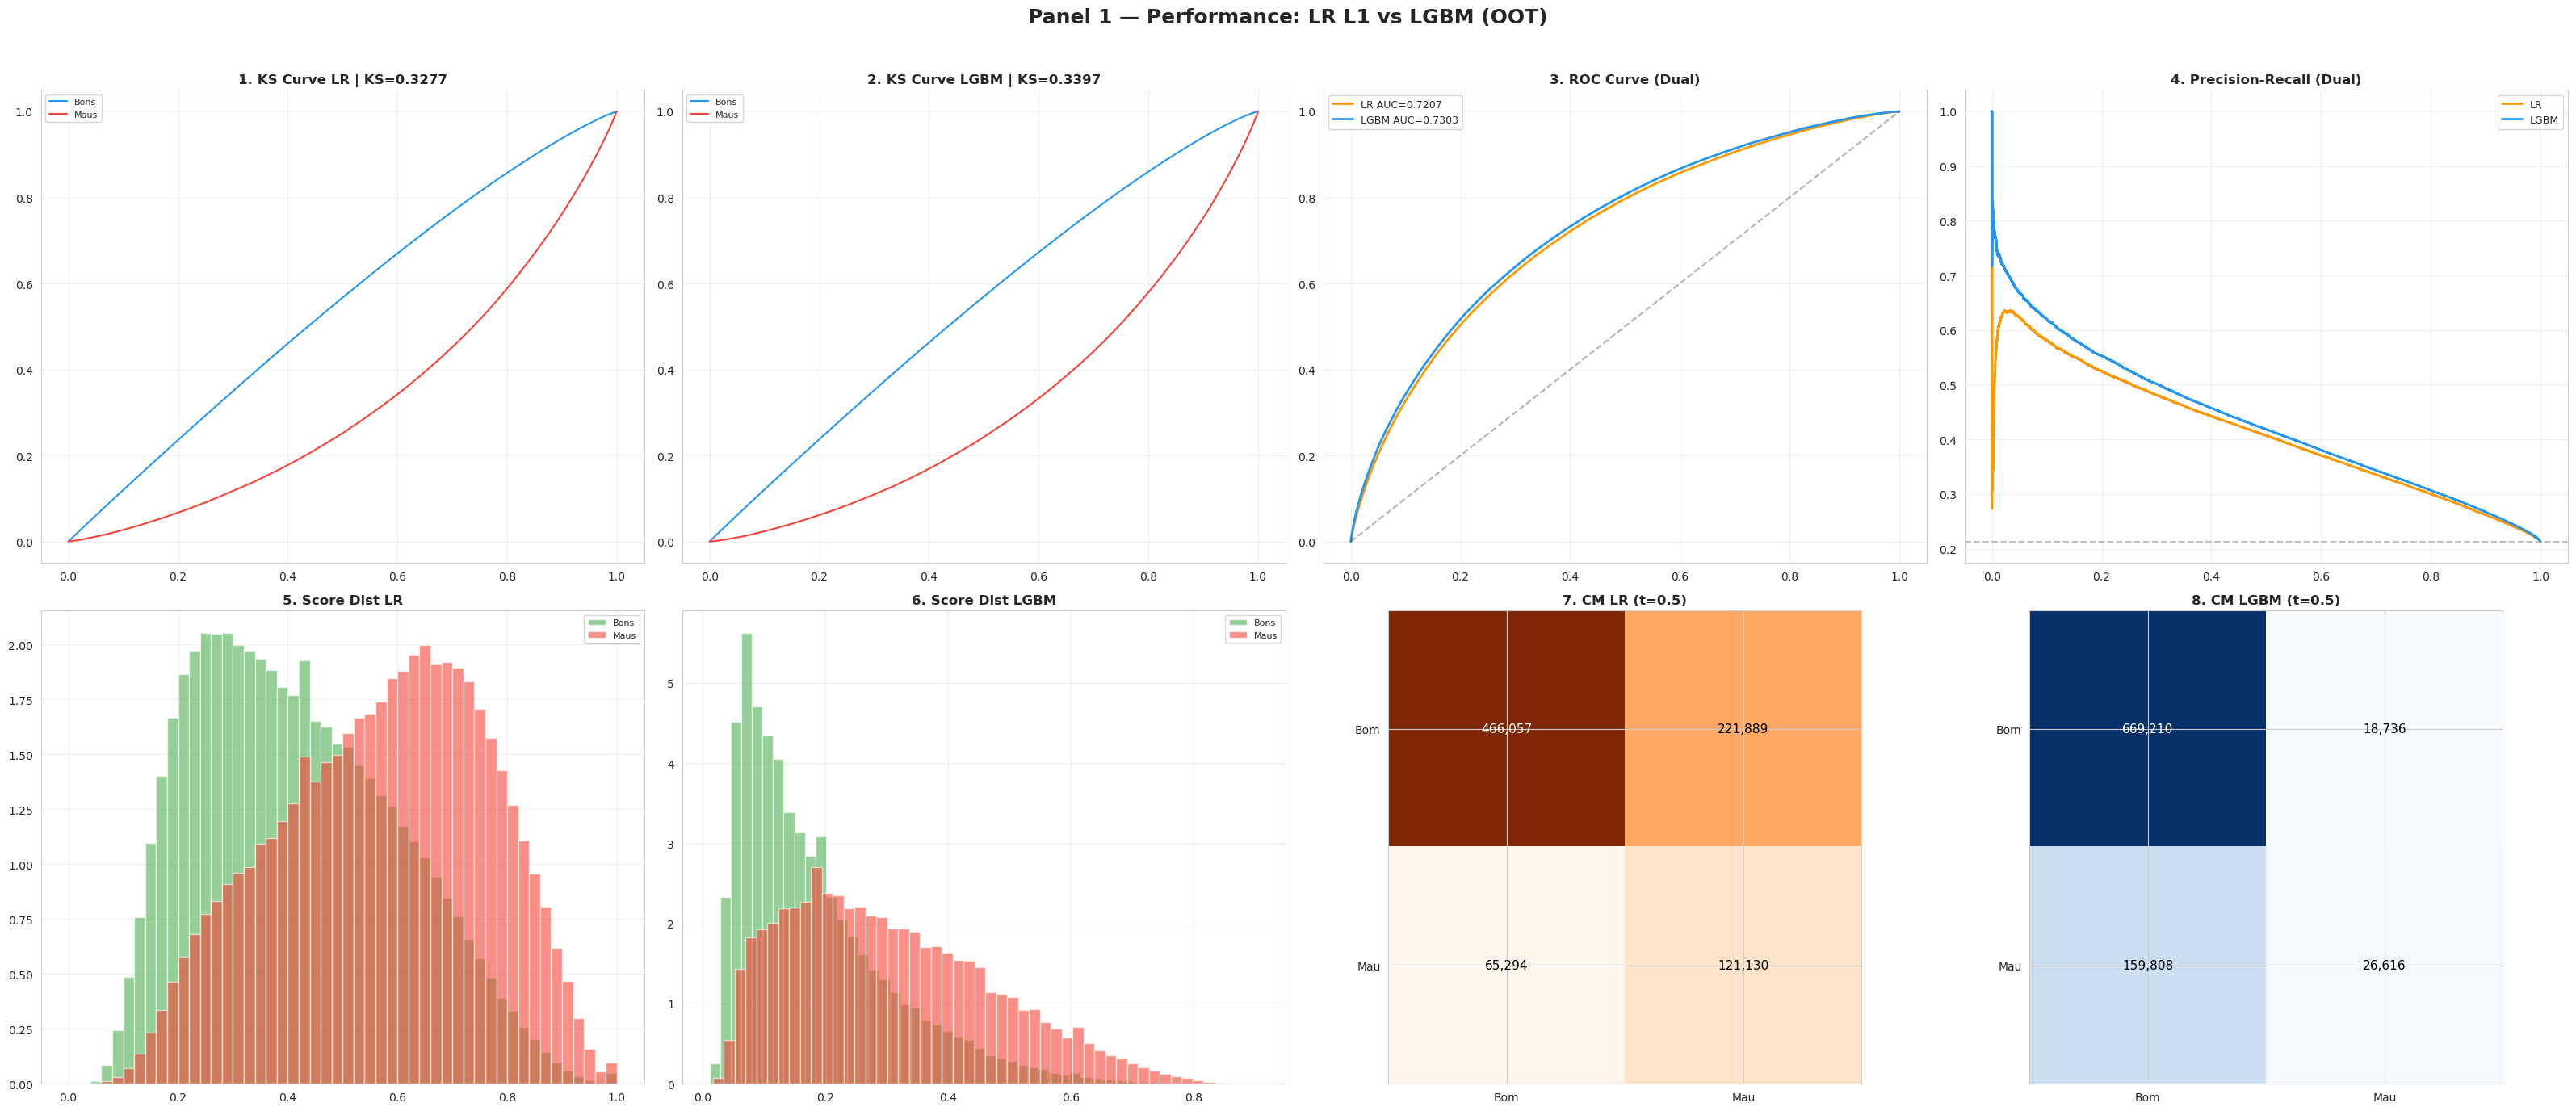

Panel 1 salvo (8 graficos)


In [30]:
# =============================================================================
# 15.1 PANEL 1 — PERFORMANCE (8 plots, 2x4)
# =============================================================================
def get_feature_color(feat):
    if feat.startswith('REC_') or '__REC_' in feat: return BOOK_COLORS['Recarga (REC_)']
    elif feat.startswith('PAG_') or '__PAG_' in feat: return BOOK_COLORS['Pagamento (PAG_)']
    elif feat.startswith('FAT_') or '__FAT_' in feat: return BOOK_COLORS['Faturamento (FAT_)']
    return BOOK_COLORS['Base (Telco+Score)']

fig, axes = plt.subplots(2, 4, figsize=(32, 14))
fig.suptitle('Panel 1 — Performance: LR L1 vs LGBM (OOT)', fontsize=18, fontweight='bold')

# Helper: KS curve data
def _ks_curve_data(y, s):
    d = pd.DataFrame({'y': y, 's': s}).sort_values('s')
    d['cg'] = (1-d['y']).cumsum()/(1-d['y']).sum()
    d['cb'] = d['y'].cumsum()/d['y'].sum()
    d['ks'] = np.abs(d['cb']-d['cg'])
    return d

# 1. KS LR
ax = axes[0,0]
d = _ks_curve_data(y_oot_agg.values, scores_oot_lr)
x = np.linspace(0,1,len(d))
ax.plot(x, d['cg'].values, label='Bons', color=COLORS['blue'])
ax.plot(x, d['cb'].values, label='Maus', color=COLORS['red'])
ks_lr = d['ks'].max()
ax.set_title(f'1. KS Curve LR | KS={ks_lr:.4f}', fontweight='bold')
ax.legend(fontsize=8); ax.grid(True, alpha=0.3)

# 2. KS LGBM
ax = axes[0,1]
d = _ks_curve_data(y_oot_agg.values, scores_oot_lgbm)
x = np.linspace(0,1,len(d))
ax.plot(x, d['cg'].values, label='Bons', color=COLORS['blue'])
ax.plot(x, d['cb'].values, label='Maus', color=COLORS['red'])
ks_lgbm = d['ks'].max()
ax.set_title(f'2. KS Curve LGBM | KS={ks_lgbm:.4f}', fontweight='bold')
ax.legend(fontsize=8); ax.grid(True, alpha=0.3)

# 3. ROC Dual
ax = axes[0,2]
fpr_lr, tpr_lr, _ = roc_curve(y_oot_agg, scores_oot_lr)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_oot_agg, scores_oot_lgbm)
auc_lr = roc_auc_score(y_oot_agg, scores_oot_lr)
auc_lgbm = roc_auc_score(y_oot_agg, scores_oot_lgbm)
ax.plot(fpr_lr, tpr_lr, color=COLORS['orange'], linewidth=2, label=f'LR AUC={auc_lr:.4f}')
ax.plot(fpr_lgbm, tpr_lgbm, color=COLORS['blue'], linewidth=2, label=f'LGBM AUC={auc_lgbm:.4f}')
ax.plot([0,1],[0,1],'k--',alpha=0.3)
ax.set_title('3. ROC Curve (Dual)', fontweight='bold'); ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

# 4. PR Dual
ax = axes[0,3]
prec_lr, rec_lr, _ = precision_recall_curve(y_oot_agg, scores_oot_lr)
prec_lgbm, rec_lgbm, _ = precision_recall_curve(y_oot_agg, scores_oot_lgbm)
ax.plot(rec_lr, prec_lr, color=COLORS['orange'], linewidth=2, label='LR')
ax.plot(rec_lgbm, prec_lgbm, color=COLORS['blue'], linewidth=2, label='LGBM')
ax.axhline(y=y_oot_agg.mean(), color='gray', linestyle='--', alpha=0.5)
ax.set_title('4. Precision-Recall (Dual)', fontweight='bold'); ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

# 5. Score Dist LR
ax = axes[1,0]
ax.hist(scores_oot_lr[y_oot_agg.values==0], bins=50, alpha=0.6, label='Bons', color=COLORS['green'], density=True)
ax.hist(scores_oot_lr[y_oot_agg.values==1], bins=50, alpha=0.6, label='Maus', color=COLORS['red'], density=True)
ax.set_title('5. Score Dist LR', fontweight='bold'); ax.legend(fontsize=8); ax.grid(True, alpha=0.3)

# 6. Score Dist LGBM
ax = axes[1,1]
ax.hist(scores_oot_lgbm[y_oot_agg.values==0], bins=50, alpha=0.6, label='Bons', color=COLORS['green'], density=True)
ax.hist(scores_oot_lgbm[y_oot_agg.values==1], bins=50, alpha=0.6, label='Maus', color=COLORS['red'], density=True)
ax.set_title('6. Score Dist LGBM', fontweight='bold'); ax.legend(fontsize=8); ax.grid(True, alpha=0.3)

# 7. CM LR
ax = axes[1,2]
y_pred_lr = (scores_oot_lr >= 0.5).astype(int)
cm_lr = confusion_matrix(y_oot_agg, y_pred_lr)
ax.imshow(cm_lr, interpolation='nearest', cmap=plt.cm.Oranges)
ax.set_title('7. CM LR (t=0.5)', fontweight='bold')
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Bom','Mau']); ax.set_yticklabels(['Bom','Mau'])
for i in range(2):
    for j in range(2):
        ax.text(j, i, f'{cm_lr[i,j]:,}', ha='center', va='center',
                color='white' if cm_lr[i,j] > cm_lr.max()/2 else 'black', fontsize=11)

# 8. CM LGBM
ax = axes[1,3]
y_pred_lgbm = (scores_oot_lgbm >= 0.5).astype(int)
cm_lgbm = confusion_matrix(y_oot_agg, y_pred_lgbm)
ax.imshow(cm_lgbm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title('8. CM LGBM (t=0.5)', fontweight='bold')
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Bom','Mau']); ax.set_yticklabels(['Bom','Mau'])
for i in range(2):
    for j in range(2):
        ax.text(j, i, f'{cm_lgbm[i,j]:,}', ha='center', va='center',
                color='white' if cm_lgbm[i,j] > cm_lgbm.max()/2 else 'black', fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f'{OUTPUT_DIR_V6}/panel1_performance_8plots.png', dpi=DPI, bbox_inches='tight')
plt.show()
print('Panel 1 salvo (8 graficos)')

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 32, Finished, Available, Finished)

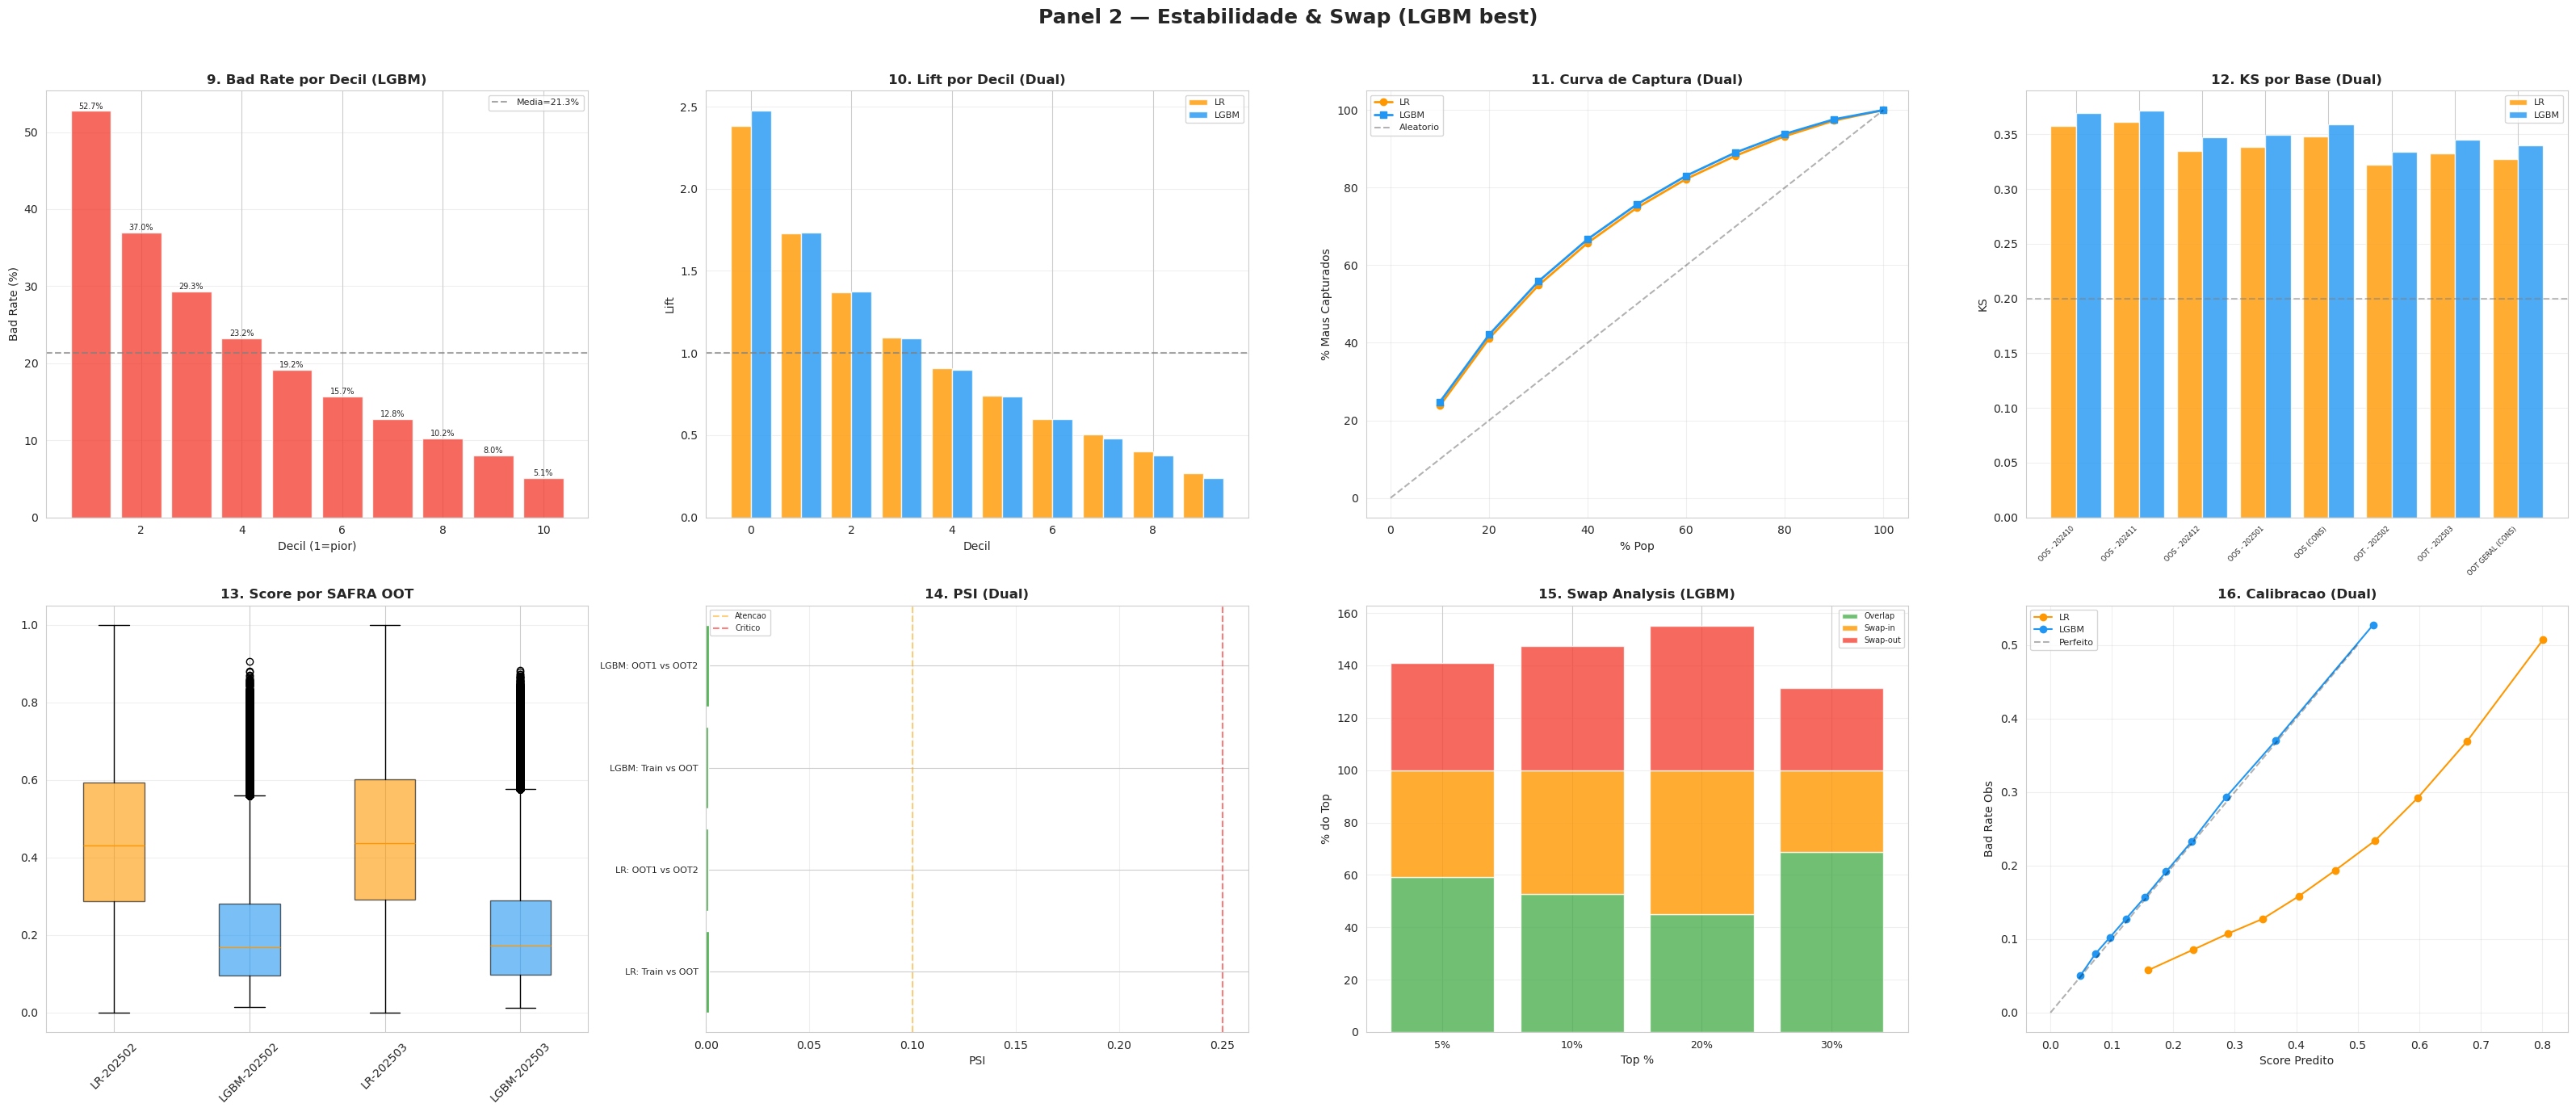

Panel 2 salvo (8 graficos)


In [31]:
# =============================================================================
# 15.2 PANEL 2 — STABILITY (8 plots, 2x4)
# =============================================================================
fig, axes = plt.subplots(2, 4, figsize=(32, 14))
fig.suptitle(f'Panel 2 — Estabilidade & Swap ({best_model_name} best)', fontsize=18, fontweight='bold')

# 9. Decile Bad Rate (best model)
ax = axes[0,0]
bars = ax.bar(dec_oot_best['decil'], dec_oot_best['bad_rate'], color=COLORS['red'], alpha=0.8, edgecolor='white')
avg_br = dec_oot_best['n_bad'].sum() / dec_oot_best['n'].sum() * 100
ax.axhline(y=avg_br, color='gray', linestyle='--', alpha=0.7, label=f'Media={avg_br:.1f}%')
ax.set_title(f'9. Bad Rate por Decil ({best_model_name})', fontweight='bold')
ax.set_xlabel('Decil (1=pior)'); ax.set_ylabel('Bad Rate (%)')
ax.legend(fontsize=8); ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, dec_oot_best['bad_rate']):
    ax.text(bar.get_x()+bar.get_width()/2, val+0.3, f'{val:.1f}%', ha='center', fontsize=7)

# 10. Lift Dual
ax = axes[0,1]
ax.bar(np.arange(len(dec_oot_lr))-0.2, dec_oot_lr['lift'], 0.4, label='LR', color=COLORS['orange'], alpha=0.8)
ax.bar(np.arange(len(dec_oot_lgbm))+0.2, dec_oot_lgbm['lift'], 0.4, label='LGBM', color=COLORS['blue'], alpha=0.8)
ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.7)
ax.set_title('10. Lift por Decil (Dual)', fontweight='bold')
ax.set_xlabel('Decil'); ax.set_ylabel('Lift'); ax.legend(fontsize=8); ax.grid(True, alpha=0.3, axis='y')

# 11. Cumulative Capture Dual
ax = axes[0,2]
ax.plot(dec_oot_lr['cum_pop_pct'], dec_oot_lr['cum_bad_pct'], 'o-', color=COLORS['orange'], linewidth=2, label='LR')
ax.plot(dec_oot_lgbm['cum_pop_pct'], dec_oot_lgbm['cum_bad_pct'], 's-', color=COLORS['blue'], linewidth=2, label='LGBM')
ax.plot([0,100],[0,100],'k--',alpha=0.3, label='Aleatorio')
ax.set_title('11. Curva de Captura (Dual)', fontweight='bold')
ax.set_xlabel('% Pop'); ax.set_ylabel('% Maus Capturados')
ax.legend(fontsize=8); ax.grid(True, alpha=0.3)

# 12. KS por Base Dual
ax = axes[0,3]
oos_oot_lr = df_results_fs[(df_results_fs['MODEL']=='LR') & (df_results_fs['BASE'].str.contains('OOS|OOT'))]
oos_oot_lgbm = df_results_fs[(df_results_fs['MODEL']=='LGBM') & (df_results_fs['BASE'].str.contains('OOS|OOT'))]
x_pos = np.arange(len(oos_oot_lr))
ax.bar(x_pos-0.2, oos_oot_lr['KS'].values, 0.4, label='LR', color=COLORS['orange'], alpha=0.8)
ax.bar(x_pos+0.2, oos_oot_lgbm['KS'].values, 0.4, label='LGBM', color=COLORS['blue'], alpha=0.8)
ax.set_xticks(x_pos); ax.set_xticklabels(oos_oot_lr['BASE'].values, rotation=45, ha='right', fontsize=6)
ax.axhline(y=0.20, color='gray', linestyle='--', alpha=0.5)
ax.set_title('12. KS por Base (Dual)', fontweight='bold'); ax.set_ylabel('KS')
ax.legend(fontsize=8); ax.grid(True, alpha=0.3, axis='y')

# 13. Score Boxplot OOT
ax = axes[1,0]
data_bp = []
labels_bp = []
for safra in safras_oot_list:
    data_bp.append(df_swap.loc[df_swap['SAFRA']==safra, 'score_lr'].values)
    labels_bp.append(f'LR-{safra}')
    data_bp.append(df_swap.loc[df_swap['SAFRA']==safra, 'score_lgbm'].values)
    labels_bp.append(f'LGBM-{safra}')
bp = ax.boxplot(data_bp, labels=labels_bp, patch_artist=True)
cols_bp = [COLORS['orange'], COLORS['blue']] * len(safras_oot_list)
for patch, c in zip(bp['boxes'], cols_bp):
    patch.set_facecolor(c); patch.set_alpha(0.6)
ax.set_title('13. Score por SAFRA OOT', fontweight='bold')
ax.tick_params(axis='x', rotation=45); ax.grid(True, alpha=0.3, axis='y')

# 14. PSI Bar
ax = axes[1,1]
psi_colors = [COLORS['green'] if r['psi']<0.1 else COLORS['orange'] if r['psi']<0.25 else COLORS['red']
              for r in psi_results]
labels_psi = [f"{r['modelo']}: {r['comparacao']}" for r in psi_results]
ax.barh(range(len(psi_results)), [r['psi'] for r in psi_results], color=psi_colors, edgecolor='white')
ax.set_yticks(range(len(psi_results))); ax.set_yticklabels(labels_psi, fontsize=8)
ax.axvline(x=0.10, color='orange', linestyle='--', alpha=0.5, label='Atencao')
ax.axvline(x=0.25, color='red', linestyle='--', alpha=0.5, label='Critico')
ax.set_title('14. PSI (Dual)', fontweight='bold'); ax.set_xlabel('PSI')
ax.legend(fontsize=7); ax.grid(True, alpha=0.3, axis='x')

# 15. Swap Stacked Bar
ax = axes[1,2]
x_sw = range(len(df_swap_results))
ax.bar(x_sw, df_swap_results['overlap_pct'], label='Overlap', color=COLORS['green'], alpha=0.8)
ax.bar(x_sw, df_swap_results['swap_in_pct'], bottom=df_swap_results['overlap_pct'],
       label='Swap-in', color=COLORS['orange'], alpha=0.8)
ax.bar(x_sw, df_swap_results['swap_out_pct'],
       bottom=df_swap_results['overlap_pct']+df_swap_results['swap_in_pct'],
       label='Swap-out', color=COLORS['red'], alpha=0.8)
ax.set_xticks(x_sw); ax.set_xticklabels(df_swap_results['cutoff'], fontsize=9)
ax.set_title(f'15. Swap Analysis ({best_model_name})', fontweight='bold')
ax.set_xlabel('Top %'); ax.set_ylabel('% do Top')
ax.legend(fontsize=7); ax.grid(True, alpha=0.3, axis='y')

# 16. Calibration Dual
ax = axes[1,3]
for name, scores, color in [('LR', scores_oot_lr, COLORS['orange']), ('LGBM', scores_oot_lgbm, COLORS['blue'])]:
    df_cal = pd.DataFrame({'y': y_oot_agg.values, 'score': scores})
    df_cal['bin'] = pd.qcut(df_cal['score'], 10, duplicates='drop')
    cal = df_cal.groupby('bin', observed=True).agg(pred=('score','mean'), obs=('y','mean')).reset_index()
    ax.plot(cal['pred'], cal['obs'], 'o-', color=color, markersize=6, label=name)
ax.plot([0, 0.5], [0, 0.5], 'k--', alpha=0.3, label='Perfeito')
ax.set_title('16. Calibracao (Dual)', fontweight='bold')
ax.set_xlabel('Score Predito'); ax.set_ylabel('Bad Rate Obs')
ax.legend(fontsize=8); ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f'{OUTPUT_DIR_V6}/panel2_stability_8plots.png', dpi=DPI, bbox_inches='tight')
plt.show()
print('Panel 2 salvo (8 graficos)')

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 33, Finished, Available, Finished)

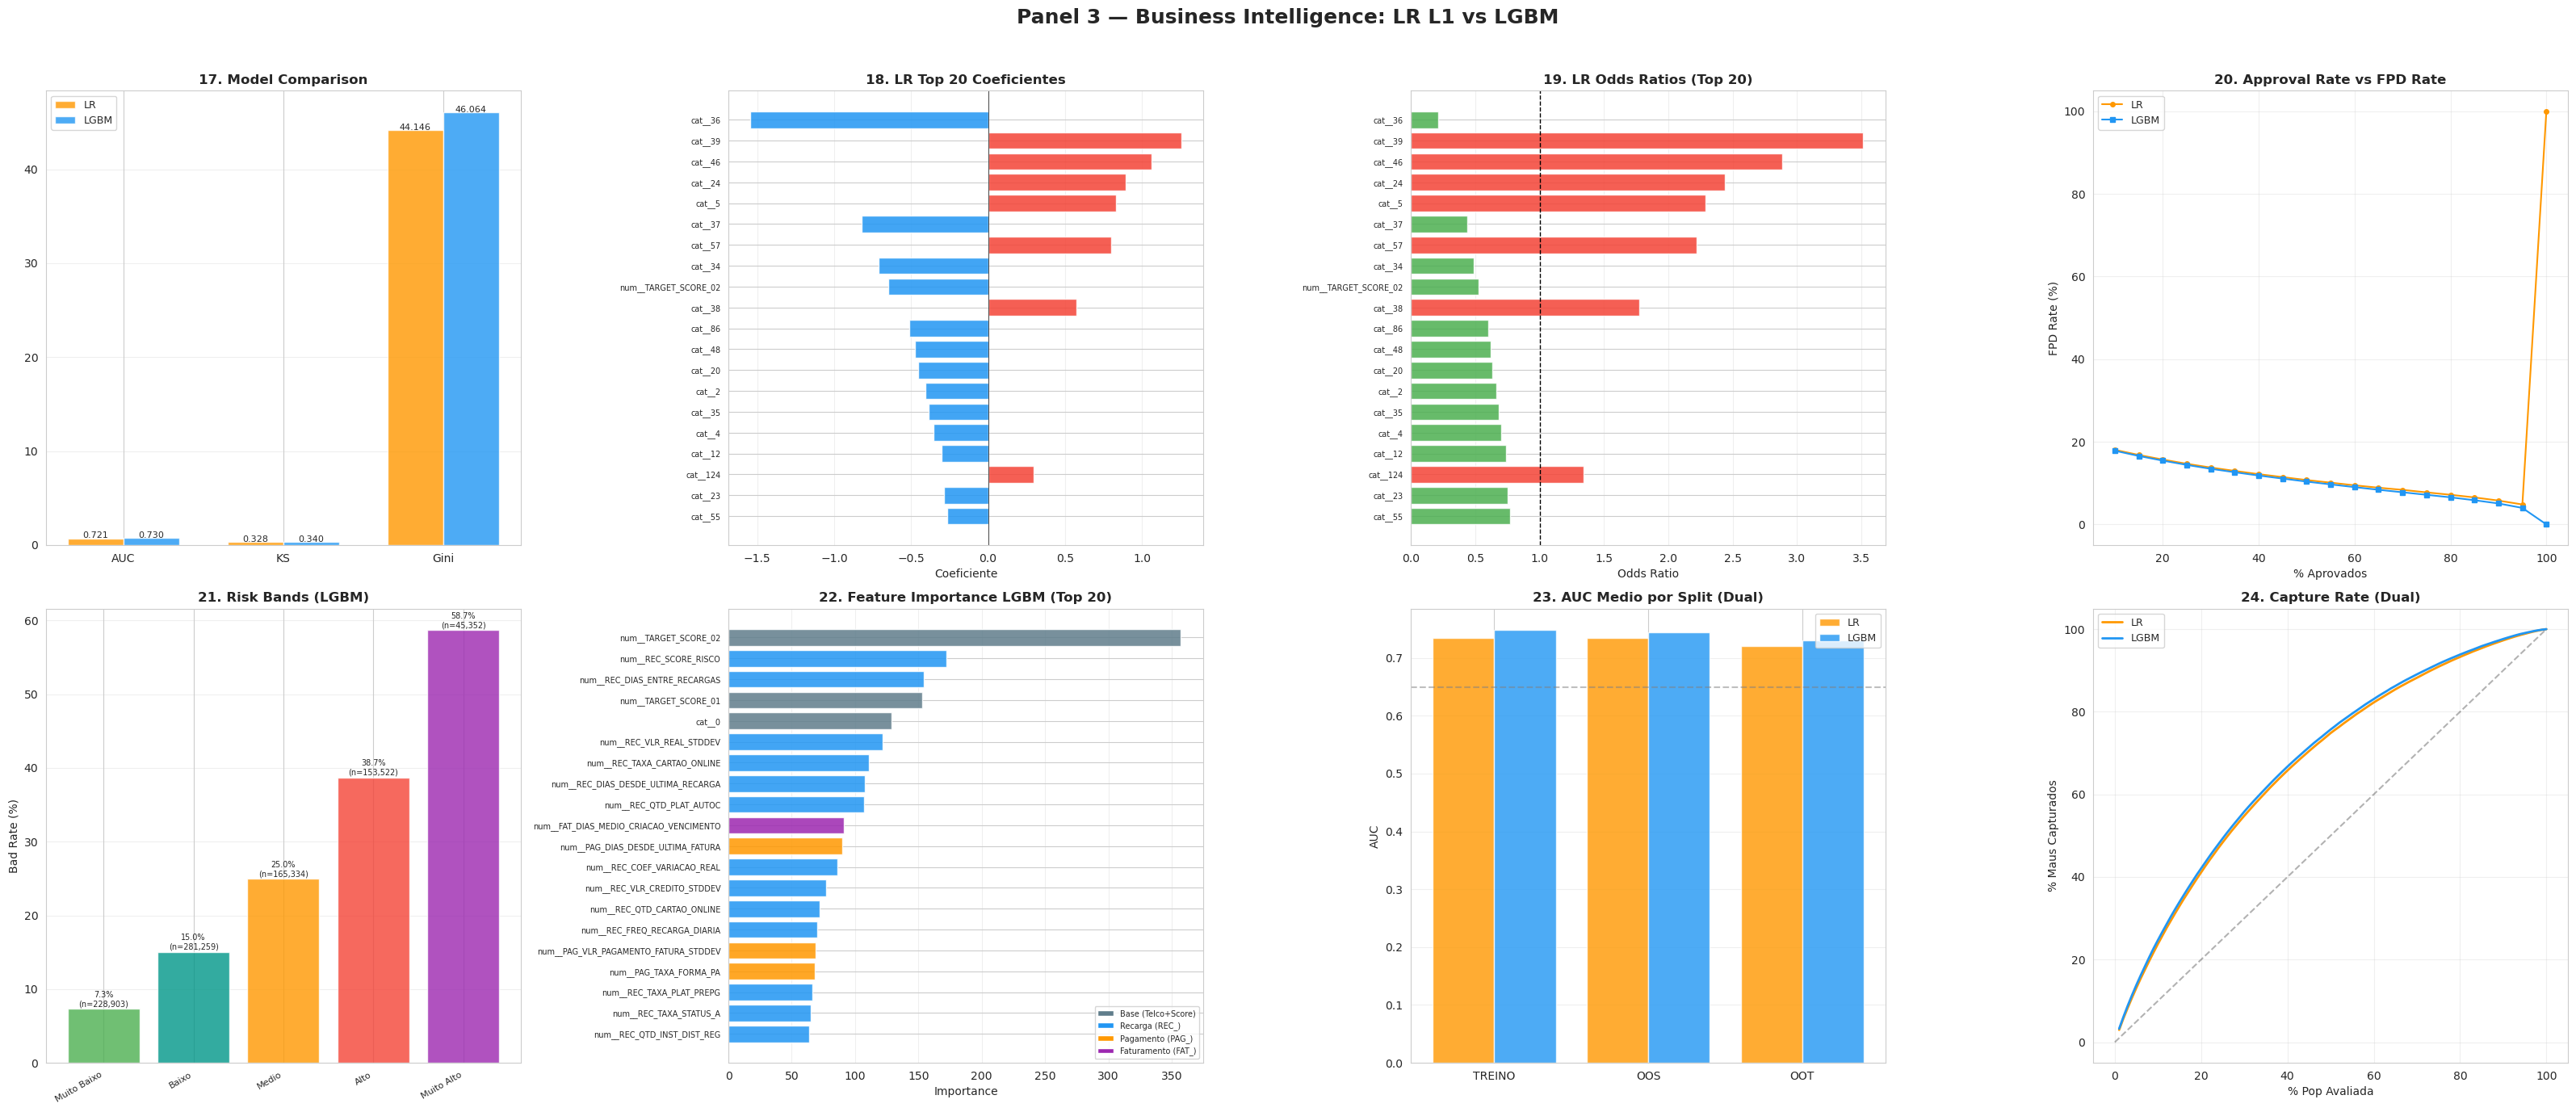

Panel 3 salvo (8 graficos)


In [32]:
# =============================================================================
# 15.3 PANEL 3 — BUSINESS (8 plots, 2x4)
# =============================================================================
fig, axes = plt.subplots(2, 4, figsize=(32, 14))
fig.suptitle('Panel 3 — Business Intelligence: LR L1 vs LGBM', fontsize=18, fontweight='bold')

# 17. Model Comparison Dashboard
ax = axes[0,0]
metrics_comp = {
    'AUC': [auc_lr, auc_lgbm],
    'KS': [ks_lr, ks_lgbm],
    'Gini': [(2*auc_lr-1)*100, (2*auc_lgbm-1)*100],
}
x_m = np.arange(len(metrics_comp))
w = 0.35
vals_lr = [v[0] for v in metrics_comp.values()]
vals_lgbm = [v[1] for v in metrics_comp.values()]
ax.bar(x_m-w/2, vals_lr, w, label='LR', color=COLORS['orange'], alpha=0.8)
ax.bar(x_m+w/2, vals_lgbm, w, label='LGBM', color=COLORS['blue'], alpha=0.8)
ax.set_xticks(x_m); ax.set_xticklabels(metrics_comp.keys())
ax.set_title('17. Model Comparison', fontweight='bold')
ax.legend(fontsize=9); ax.grid(True, alpha=0.3, axis='y')
for i, (vl, vg) in enumerate(zip(vals_lr, vals_lgbm)):
    ax.text(i-w/2, vl+0.005, f'{vl:.3f}', ha='center', fontsize=8)
    ax.text(i+w/2, vg+0.005, f'{vg:.3f}', ha='center', fontsize=8)

# 18. LR Top 20 Coefs
ax = axes[0,1]
top20_coefs = df_coefs.head(20)
colors_coef = ['#F44336' if c > 0 else '#2196F3' for c in top20_coefs['coef']]
ax.barh(range(len(top20_coefs)-1,-1,-1), top20_coefs['coef'].values, color=colors_coef, alpha=0.85)
ax.set_yticks(range(len(top20_coefs)-1,-1,-1))
ax.set_yticklabels(top20_coefs['feature'].values, fontsize=7)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_title('18. LR Top 20 Coeficientes', fontweight='bold')
ax.set_xlabel('Coeficiente'); ax.grid(True, alpha=0.3, axis='x')

# 19. LR Odds Ratios (top 20)
ax = axes[0,2]
top20_or = df_coefs.head(20).copy()
top20_or['or_display'] = top20_or['odds_ratio'].clip(upper=5)
colors_or = [COLORS['red'] if o > 1 else COLORS['green'] for o in top20_or['odds_ratio']]
ax.barh(range(len(top20_or)-1,-1,-1), top20_or['or_display'].values, color=colors_or, alpha=0.85)
ax.set_yticks(range(len(top20_or)-1,-1,-1))
ax.set_yticklabels(top20_or['feature'].values, fontsize=7)
ax.axvline(x=1.0, color='black', linewidth=1, linestyle='--')
ax.set_title('19. LR Odds Ratios (Top 20)', fontweight='bold')
ax.set_xlabel('Odds Ratio'); ax.grid(True, alpha=0.3, axis='x')

# 20. Approval Rate vs FPD Rate
ax = axes[0,3]
pcts = np.linspace(0.1, 1.0, 19)
approval_fpd_lr = []
approval_fpd_lgbm = []
for p in pcts:
    pctl = np.clip((1-p)*100, 0, 100)
    thresh_lr = np.percentile(scores_oot_lr, pctl)
    approved_lr = y_oot_agg.values[scores_oot_lr <= thresh_lr]
    approval_fpd_lr.append(approved_lr.mean()*100 if len(approved_lr)>0 else 0)
    thresh_lgbm = np.percentile(scores_oot_lgbm, pctl)
    approved_lgbm = y_oot_agg.values[scores_oot_lgbm <= thresh_lgbm]
    approval_fpd_lgbm.append(approved_lgbm.mean()*100 if len(approved_lgbm)>0 else 0)
ax.plot(pcts*100, approval_fpd_lr, 'o-', color=COLORS['orange'], label='LR', markersize=4)
ax.plot(pcts*100, approval_fpd_lgbm, 's-', color=COLORS['blue'], label='LGBM', markersize=4)
ax.set_title('20. Approval Rate vs FPD Rate', fontweight='bold')
ax.set_xlabel('% Aprovados'); ax.set_ylabel('FPD Rate (%)')
ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

# 21. Risk Bands (best model)
ax = axes[1,0]
df_risk = pd.DataFrame({'score': scores_oot_best, 'FPD': y_oot_agg.values})
df_risk['band'] = pd.cut(df_risk['score'], bins=[0,0.1,0.2,0.3,0.5,1.0],
                          labels=['Muito Baixo','Baixo','Medio','Alto','Muito Alto'])
risk_stats = df_risk.groupby('band', observed=True).agg(n=('FPD','count'), bad_rate=('FPD','mean')).reset_index()
risk_stats['bad_rate'] = risk_stats['bad_rate'] * 100
bar_colors = [COLORS['green'], COLORS['teal'], COLORS['orange'], COLORS['red'], COLORS['purple']]
bars_r = ax.bar(range(len(risk_stats)), risk_stats['bad_rate'], color=bar_colors[:len(risk_stats)], alpha=0.8)
ax.set_xticks(range(len(risk_stats))); ax.set_xticklabels(risk_stats['band'], rotation=30, ha='right', fontsize=8)
ax.set_title(f'21. Risk Bands ({best_model_name})', fontweight='bold')
ax.set_ylabel('Bad Rate (%)'); ax.grid(True, alpha=0.3, axis='y')
for bar, val, n in zip(bars_r, risk_stats['bad_rate'], risk_stats['n']):
    ax.text(bar.get_x()+bar.get_width()/2, val+0.3, f'{val:.1f}%\n(n={n:,})', ha='center', fontsize=7)

# 22. Feature Importance LGBM by Book (top 20)
ax = axes[1,1]
lgbm_final_model = pipelines_final['LGBM'].named_steps['model']
try:
    fn_lgbm_final = pipelines_final['LGBM'].named_steps['prep'].get_feature_names_out()
except Exception:
    nf_f = [n for n in X_tr_final_fs.select_dtypes(include=['int32','int64','float32','float64']).columns if n != 'SAFRA']
    cf_f = [c for c in X_tr_final_fs.select_dtypes(include=['object','category']).columns if c != 'NUM_CPF']
    fn_lgbm_final = nf_f + cf_f
df_imp_final = pd.DataFrame({'feature': fn_lgbm_final, 'importance': lgbm_final_model.feature_importances_})
df_imp_final = df_imp_final.sort_values('importance', ascending=False).head(20)
colors_imp = [get_feature_color(f.split('__')[-1] if '__' in f else f) for f in df_imp_final['feature']]
ax.barh(range(len(df_imp_final)-1,-1,-1), df_imp_final['importance'].values, color=colors_imp, alpha=0.85)
ax.set_yticks(range(len(df_imp_final)-1,-1,-1))
ax.set_yticklabels(df_imp_final['feature'].values, fontsize=7)
ax.set_title('22. Feature Importance LGBM (Top 20)', fontweight='bold')
ax.set_xlabel('Importance'); ax.grid(True, alpha=0.3, axis='x')
legend_elements = [Patch(facecolor=c, label=l) for l, c in BOOK_COLORS.items()]
ax.legend(handles=legend_elements, loc='lower right', fontsize=7)

# 23. AUC por Split Dual
ax = axes[1,2]
groups = {'TREINO': {'LR': [], 'LGBM': []}, 'OOS': {'LR': [], 'LGBM': []}, 'OOT': {'LR': [], 'LGBM': []}}
for _, row in df_results_fs.iterrows():
    if 'TREINO' in row['BASE'] and 'CONS' not in row['BASE']:
        groups['TREINO'][row['MODEL']].append(row['AUC'])
    elif 'OOS' in row['BASE'] and 'CONS' not in row['BASE']:
        groups['OOS'][row['MODEL']].append(row['AUC'])
    elif 'OOT' in row['BASE'] and 'CONS' not in row['BASE']:
        groups['OOT'][row['MODEL']].append(row['AUC'])
x_g = np.arange(3)
lr_means = [np.mean(groups[g]['LR']) if groups[g]['LR'] else 0 for g in ['TREINO','OOS','OOT']]
lgbm_means = [np.mean(groups[g]['LGBM']) if groups[g]['LGBM'] else 0 for g in ['TREINO','OOS','OOT']]
ax.bar(x_g-0.2, lr_means, 0.4, label='LR', color=COLORS['orange'], alpha=0.8)
ax.bar(x_g+0.2, lgbm_means, 0.4, label='LGBM', color=COLORS['blue'], alpha=0.8)
ax.set_xticks(x_g); ax.set_xticklabels(['TREINO','OOS','OOT'])
ax.axhline(y=0.65, color='gray', linestyle='--', alpha=0.5)
ax.set_title('23. AUC Medio por Split (Dual)', fontweight='bold'); ax.set_ylabel('AUC')
ax.legend(fontsize=9); ax.grid(True, alpha=0.3, axis='y')

# 24. Capture Rate Dual
ax = axes[1,3]
pcts_cap = np.linspace(0.01, 1.0, 100)
cap_lr = []; cap_lgbm = []
for p in pcts_cap:
    n = int(total_pop * p)
    top_lr = df_swap.nlargest(n, 'score_lr').index
    top_lgbm = df_swap.nlargest(n, 'score_lgbm').index
    cap_lr.append((df_swap.loc[top_lr, 'FPD'] == 1).sum() / total_bad * 100)
    cap_lgbm.append((df_swap.loc[top_lgbm, 'FPD'] == 1).sum() / total_bad * 100)
ax.plot(pcts_cap*100, cap_lr, color=COLORS['orange'], linewidth=2, label='LR')
ax.plot(pcts_cap*100, cap_lgbm, color=COLORS['blue'], linewidth=2, label='LGBM')
ax.plot([0,100],[0,100],'k--',alpha=0.3)
ax.set_title('24. Capture Rate (Dual)', fontweight='bold')
ax.set_xlabel('% Pop Avaliada'); ax.set_ylabel('% Maus Capturados')
ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f'{OUTPUT_DIR_V6}/panel3_business_8plots.png', dpi=DPI, bbox_inches='tight')
plt.show()
print('Panel 3 salvo (8 graficos)')

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 34, Finished, Available, Finished)

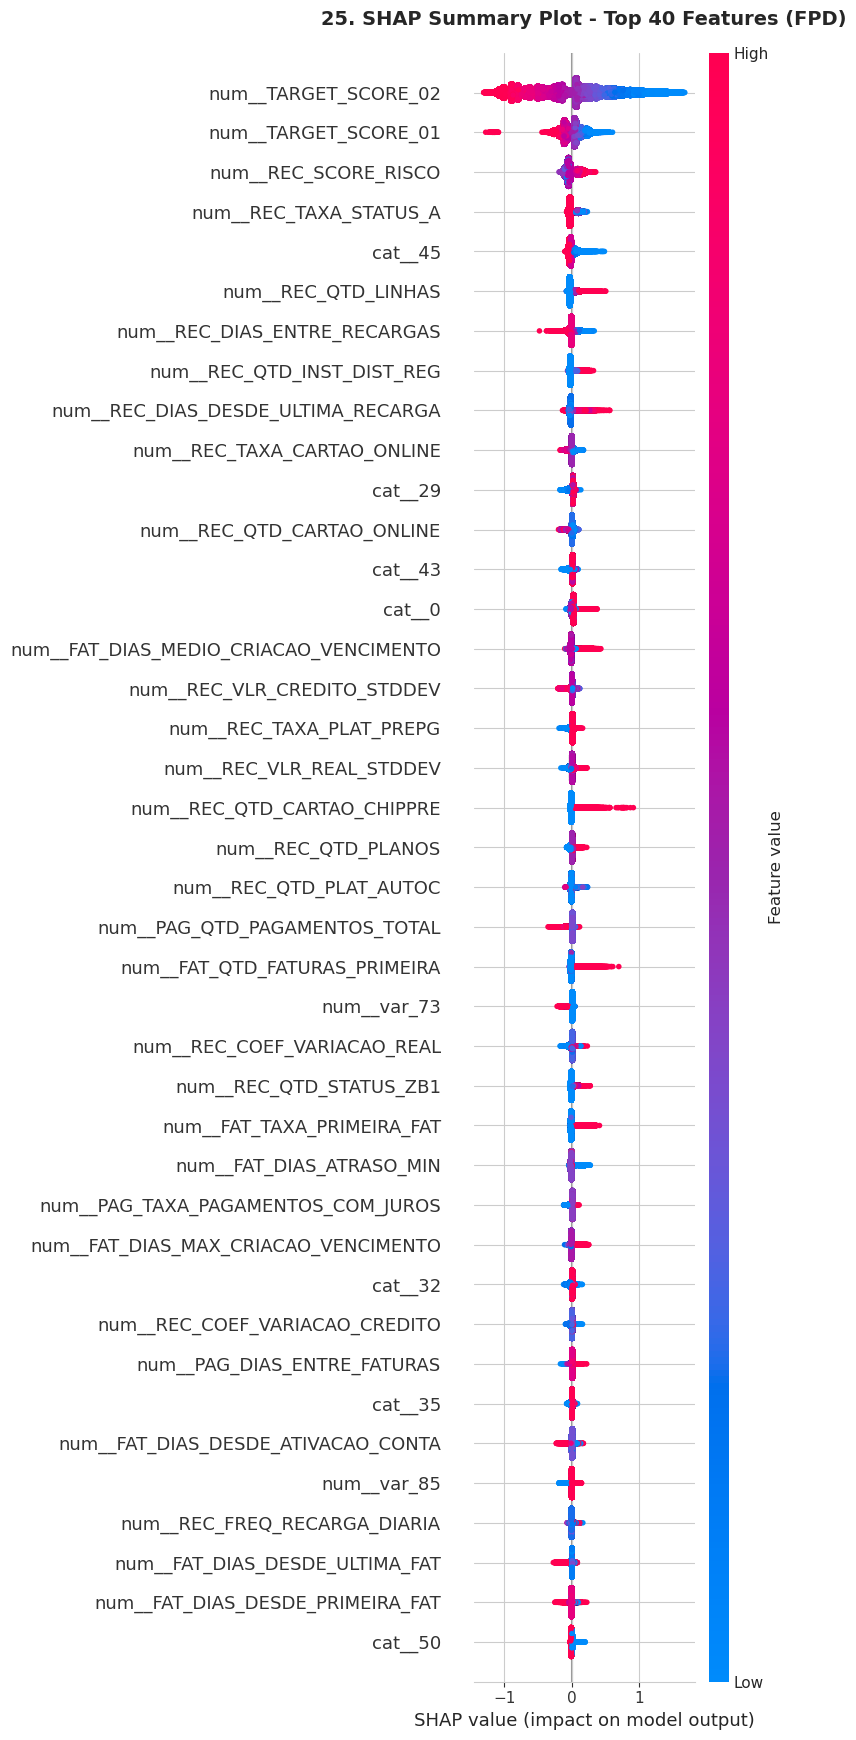

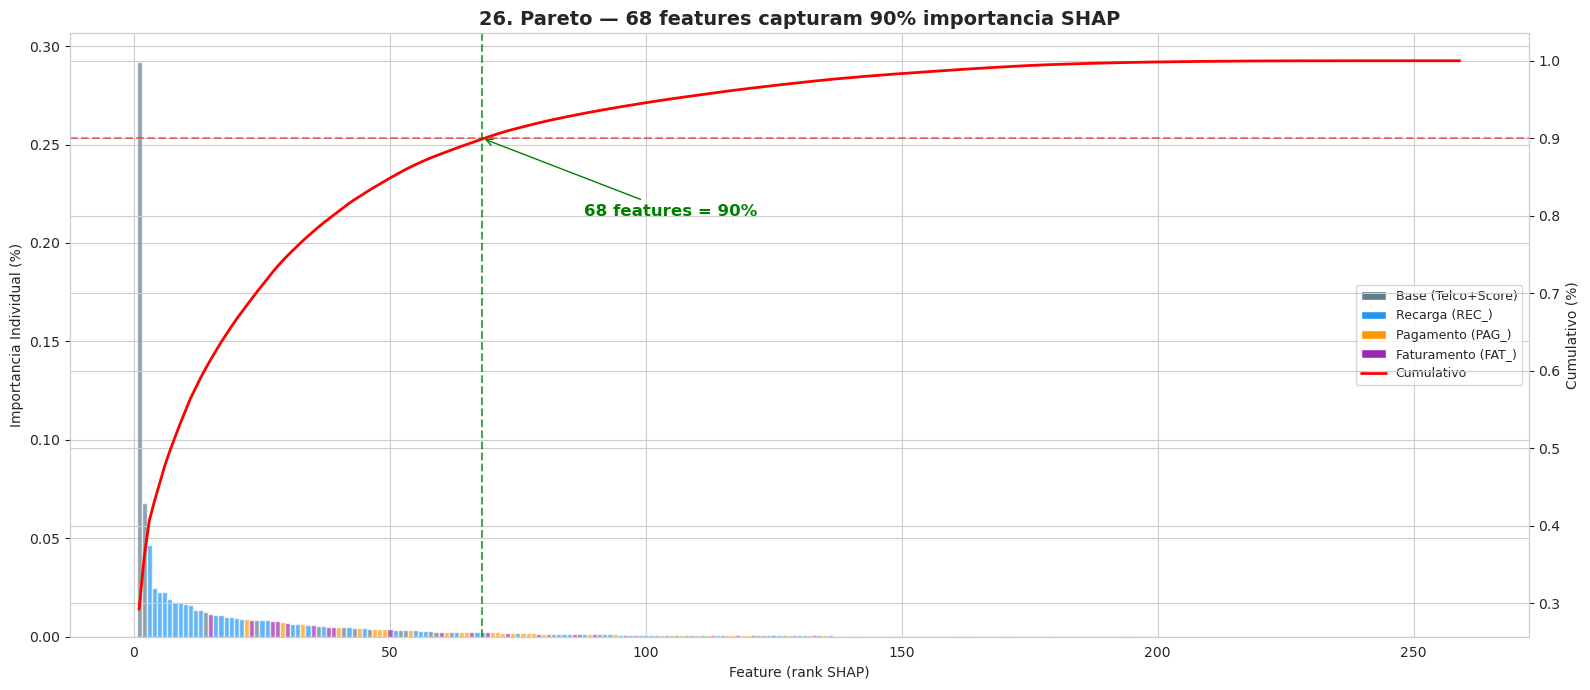

SHAP plots salvos (2 graficos)


In [33]:
# =============================================================================
# 15.4 SHAP VISUALIZACOES STANDALONE
# =============================================================================

# 25. SHAP Beeswarm (top 40)
fig, ax = plt.subplots(figsize=(14, 16))
shap.summary_plot(shap_vals, X_shap_transformed,
                  feature_names=list(transformed_names), max_display=40, show=False)
plt.title('25. SHAP Summary Plot - Top 40 Features (FPD)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR_V6}/shap_beeswarm_top40.png', dpi=DPI, bbox_inches='tight')
plt.show()

# 26. Pareto Cumulative
fig, ax = plt.subplots(figsize=(16, 7))
x_range = range(1, len(df_shap_ranking) + 1)
colors_cum = [get_feature_color(f) for f in df_shap_ranking['feature']]
ax.bar(x_range, df_shap_ranking['pct_importance'].values, color=colors_cum, alpha=0.7, width=1.0)
ax2_p = ax.twinx()
ax2_p.plot(x_range, df_shap_ranking['cumulative_pct'].values, color='red', linewidth=2)
ax2_p.axhline(y=CUMULATIVE_THRESHOLD, color='red', linestyle='--', alpha=0.5)
n_90 = (df_shap_ranking['cumulative_pct'] <= CUMULATIVE_THRESHOLD).sum()
ax2_p.axvline(x=n_90, color='green', linestyle='--', alpha=0.7)
ax2_p.annotate(f'{n_90} features = 90%', xy=(n_90, 0.90), xytext=(n_90+20, 0.80),
              arrowprops=dict(arrowstyle='->', color='green'), fontsize=12, fontweight='bold', color='green')
ax.set_xlabel('Feature (rank SHAP)'); ax.set_ylabel('Importancia Individual (%)')
ax2_p.set_ylabel('Cumulativo (%)')
ax.set_title(f'26. Pareto — {n_90} features capturam 90% importancia SHAP', fontsize=14, fontweight='bold')
legend_elems = [Patch(facecolor=c, label=l) for l, c in BOOK_COLORS.items()]
legend_elems.append(Line2D([0],[0], color='red', linewidth=2, label='Cumulativo'))
ax.legend(handles=legend_elems, loc='center right', fontsize=9)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR_V6}/shap_pareto_cumulative.png', dpi=DPI, bbox_inches='tight')
plt.show()
print('SHAP plots salvos (2 graficos)')

In [34]:
# =============================================================================
# 15.5 KS INCREMENTAL VISUALIZATION
# COMENTADO — depende de df_results_ks_inc (secao 10.2)
# =============================================================================
# fig, ax = plt.subplots(figsize=(14, 7))
# 
# oot_ks_inc = df_results_ks_inc[df_results_ks_inc['BASE'] == 'OOT GERAL (CONS)']
# steps_order = ['Score1', 'Score1+Score2', '+Cadastro', '+Telco', '+Recarga', '+Pagamento', '+Faturamento']
# 
# for model_name, color, marker in [('LR', COLORS['orange'], 'o'), ('LGBM', COLORS['blue'], 's')]:
#     model_data = oot_ks_inc[oot_ks_inc['MODELO'] == model_name]
#     ks_vals = []
#     for step in steps_order:
#         row = model_data[model_data['CONJ FEATURES'] == step]
#         ks_vals.append(row['KS'].values[0] if len(row) > 0 else 0)
#     ax.plot(range(len(steps_order)), ks_vals, f'{marker}-', color=color, linewidth=2.5,
#             markersize=10, label=model_name)
#     for i, v in enumerate(ks_vals):
#         ax.annotate(f'{v:.3f}', xy=(i, v), xytext=(0, 10), textcoords='offset points',
#                    ha='center', fontsize=9, fontweight='bold', color=color)
# 
# ax.set_xticks(range(len(steps_order)))
# ax.set_xticklabels(steps_order, rotation=30, ha='right', fontsize=10)
# ax.set_xlabel('Conjunto de Features (incremental)', fontsize=11)
# ax.set_ylabel('KS (OOT)', fontsize=11)
# ax.set_title('KS Incremental por Fonte de Dados — LR L1 vs LGBM (OOT)', fontsize=14, fontweight='bold')
# ax.legend(fontsize=12)
# ax.grid(True, alpha=0.3)
# 
# plt.tight_layout()
# plt.savefig(f'{OUTPUT_DIR_V6}/ks_incremental_dual.png', dpi=DPI, bbox_inches='tight')
# plt.show()
# print('KS Incremental plot salvo')

print('KS Incremental viz SKIP (comentado)')

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 35, Finished, Available, Finished)

KS Incremental viz SKIP (comentado)


## 16. Export & MLflow Registry

- Log todas visualizacoes + CSVs no MLflow
- Export AMBOS modelos via `export_model()`
- Promover melhor modelo para Production

In [35]:
# =============================================================================
# 16.1 LOG VISUALIZACOES NO MLFLOW
# =============================================================================
import glob as glob_mod

with mlflow.start_run(run_name='Final_Visualizations_v6') as run_viz:
    mlflow.set_tag('task', 'visualization')
    mlflow.set_tag('version', 'v6')

    for fig_path in glob_mod.glob(f'{OUTPUT_DIR_V6}/*.png'):
        mlflow.log_artifact(fig_path, 'plots_v6')

    # Salvar CSVs
    df_swap_results.to_csv(f'{OUTPUT_DIR_V6}/swap_analysis_results.csv', index=False)
    dec_oot_best.to_csv(f'{OUTPUT_DIR_V6}/decile_analysis_oot.csv', index=False)
    df_psi.to_csv(f'{OUTPUT_DIR_V6}/psi_results.csv', index=False)
    df_results_fs.to_csv(f'{OUTPUT_DIR_V6}/model_comparison_results.csv', index=False)
    if 'df_results_ks_inc' in dir():
        df_results_ks_inc.to_csv(f'{OUTPUT_DIR_V6}/ks_incremental_results.csv', index=False)

    for csv_path in glob_mod.glob(f'{OUTPUT_DIR_V6}/*.csv'):
        mlflow.log_artifact(csv_path, 'analysis_v6')

    # Metricas OOT
    mlflow.log_metric('ks_oot_lr', ks_lr)
    mlflow.log_metric('ks_oot_lgbm', ks_lgbm)
    mlflow.log_metric('auc_oot_lr', auc_lr)
    mlflow.log_metric('auc_oot_lgbm', auc_lgbm)
    mlflow.log_metric('gini_oot_lr', (2*auc_lr-1)*100)
    mlflow.log_metric('gini_oot_lgbm', (2*auc_lgbm-1)*100)

    psi_best = [r for r in psi_results if r['modelo']==best_model_name and r['comparacao']=='Train vs OOT']
    if psi_best:
        mlflow.log_metric('psi_train_vs_oot', psi_best[0]['psi'])

    print(f'MLflow Run ID (viz): {run_viz.info.run_id}')
    print(f'Visualizacoes + CSVs logados no MLflow')

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 36, Finished, Available, Finished)

MLflow Run ID (viz): 0e2dca60-c870-4717-8ace-0aa2655218a5
Visualizacoes + CSVs logados no MLflow


In [36]:
# =============================================================================
# 16.2 EXPORT AMBOS MODELOS VIA MLFLOW REGISTRY
# =============================================================================
sys.path.insert(0, '/lakehouse/default/Files/projeto-final/utils')
from export_model import export_model, promote_to_production

feature_names_export = [f for f in final_set_features if f not in ['NUM_CPF', 'SAFRA']]
X_oot_exp = X_oot_fs.drop(columns=['NUM_CPF', 'SAFRA'], errors='ignore')
X_oos_exp = X_oos_fs.drop(columns=['NUM_CPF', 'SAFRA'], errors='ignore')

# Metricas comuns
def _compute_export_metrics(pipe, model_label):
    ks_oot = ks_stat(y_oot_agg, pipe.predict_proba(X_oot_fs)[:, 1])
    auc_oot = roc_auc_score(y_oot_agg, pipe.predict_proba(X_oot_fs)[:, 1])
    ks_oos = ks_stat(y_oos_agg, pipe.predict_proba(X_oos_fs)[:, 1])
    auc_oos = roc_auc_score(y_oos_agg, pipe.predict_proba(X_oos_fs)[:, 1])
    m = {
        'ks_oot': ks_oot, 'auc_oot': auc_oot,
        'ks_oos': ks_oos, 'auc_oos': auc_oos,
        'gini_oot': (2*auc_oot-1)*100, 'gini_oos': (2*auc_oos-1)*100,
        'n_features': len(feature_names_export), 'version': 'v6',
    }
    # OOS 202501 especifico (para validacao_deploy)
    X_501, y_501 = filter_xy_by_safra(X_oos_fs, y_oos_agg, [202501])
    if len(y_501) > 0:
        p = pipe.predict_proba(X_501)[:, 1]
        m['ks_oos_202501'] = ks_stat(y_501, p)
        m['auc_oos_202501'] = roc_auc_score(y_501, p)
        m['gini_oos_202501'] = (2*m['auc_oos_202501']-1)*100
    return m

# Export LR
print('=== Export LR L1 ===')
metrics_lr = _compute_export_metrics(pipelines_final['LR'], 'lr')
result_lr = export_model(
    pipeline=pipelines_final['LR'], model_name='lr_l1_v6',
    X_test=X_oot_exp, y_test=y_oot_agg,
    feature_names=feature_names_export, metrics_dict=metrics_lr,
)
print(f"  Registered: {result_lr['registered_name']}")
print(f"  KS OOT: {metrics_lr['ks_oot']:.5f}, AUC OOT: {metrics_lr['auc_oot']:.5f}")

# Export LGBM
print('\n=== Export LGBM ===')
metrics_lgbm = _compute_export_metrics(pipelines_final['LGBM'], 'lgbm')
result_lgbm = export_model(
    pipeline=pipelines_final['LGBM'], model_name='lgbm_baseline_v6',
    X_test=X_oot_exp, y_test=y_oot_agg,
    feature_names=feature_names_export, metrics_dict=metrics_lgbm,
)
print(f"  Registered: {result_lgbm['registered_name']}")
print(f"  KS OOT: {metrics_lgbm['ks_oot']:.5f}, AUC OOT: {metrics_lgbm['auc_oot']:.5f}")

# Promover melhor modelo para Production
print(f"\n{'='*60}")
print(f'Promovendo melhor modelo ({best_model_name}) para Production...')
if best_model_name == 'LR':
    best_result = result_lr
else:
    best_result = result_lgbm
version = promote_to_production(best_result['registered_name'])
print(f"Modelo {best_result['registered_name']} v{version} em Production!")
print(f"{'='*60}")

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 37, Finished, Available, Finished)

=== Export LR L1 ===
Modelo salvo: /lakehouse/default/Files/projeto-final/5-treinamento-modelos/artifacts/lr_l1_v6_20260210_181142.pkl
Verificacao .pkl: OK (shape predito: (5, 2))
Verificacao range probabilidades: OK (min=0.0727, max=0.9273)
Metadata salvo: /lakehouse/default/Files/projeto-final/5-treinamento-modelos/artifacts/lr_l1_v6_metadata_20260210_181142.json
MLflow Run ID: b02099ef-431d-4558-96da-d6cfcc27b61f


Successfully registered model 'credit-risk-fpd-lr_l1_v6'.


Modelo credit-risk-fpd-lr_l1_v6 v1 transicionado para Staging
  Registered: credit-risk-fpd-lr_l1_v6
  KS OOT: 0.32767, AUC OOT: 0.72073

=== Export LGBM ===
Modelo salvo: /lakehouse/default/Files/projeto-final/5-treinamento-modelos/artifacts/lgbm_baseline_v6_20260210_181212.pkl
Verificacao .pkl: OK (shape predito: (5, 2))
Verificacao range probabilidades: OK (min=0.1044, max=0.8956)
Metadata salvo: /lakehouse/default/Files/projeto-final/5-treinamento-modelos/artifacts/lgbm_baseline_v6_metadata_20260210_181212.json
MLflow Run ID: ff5a5273-8426-46ed-89d5-c43df94552cb


Successfully registered model 'credit-risk-fpd-lgbm_baseline_v6'.


Modelo credit-risk-fpd-lgbm_baseline_v6 v1 transicionado para Staging
  Registered: credit-risk-fpd-lgbm_baseline_v6
  KS OOT: 0.33974, AUC OOT: 0.73032

Promovendo melhor modelo (LGBM) para Production...
Modelo credit-risk-fpd-lgbm_baseline_v6 v1 promovido para Production
Modelo credit-risk-fpd-lgbm_baseline_v6 v1 em Production!


In [37]:
# =============================================================================
# 17. RESUMO FINAL
# =============================================================================
print('=' * 70)
print('  MODELO BASELINE v6 — RESUMO FINAL')
print('=' * 70)
print(f'\n  Melhor Modelo: {best_model_name}')
print(f'  KS OOT:  {best_ks_oot:.5f}')
if best_model_name == 'LR':
    best_metrics = metrics_lr
else:
    best_metrics = metrics_lgbm
print(f'  AUC OOT: {best_metrics["auc_oot"]:.5f}')
print(f'  Gini OOT: {best_metrics["gini_oot"]:.1f}%')
print(f'  KS OOS:  {best_metrics["ks_oos"]:.5f}')
print(f'  Features SHAP: {len(final_set_features)}')
print(f'\n  Comparacao:')
print(f'    LR L1:  KS={metrics_lr["ks_oot"]:.5f}  AUC={metrics_lr["auc_oot"]:.5f}  Gini={metrics_lr["gini_oot"]:.1f}%')
print(f'    LGBM:   KS={metrics_lgbm["ks_oot"]:.5f}  AUC={metrics_lgbm["auc_oot"]:.5f}  Gini={metrics_lgbm["gini_oot"]:.1f}%')
print(f'\n  PSI:')
for r in psi_results:
    print(f'    {r["modelo"]} {r["comparacao"]}: {r["psi"]:.4f} [{r["status"]}]')
print(f'\n  Visualizacoes: 26 graficos em {OUTPUT_DIR_V6}/')
print(f'  MLflow: Ambos modelos registrados, {best_model_name} em Production')
print(f'\n  Modelos exportados:')
print(f'    LR:   {result_lr["registered_name"]}')
print(f'    LGBM: {result_lgbm["registered_name"]}')
print(f'\n{"="*70}')
print('  v6 completo — dual model + 26 viz + swap corrigido + SHAP + PSI')
print(f'{"="*70}')

StatementMeta(, 9b66882c-a4f9-444d-a166-c5677c89b7f2, 38, Finished, Available, Finished)

  MODELO BASELINE v6 — RESUMO FINAL

  Melhor Modelo: LGBM
  KS OOT:  0.33974
  AUC OOT: 0.73032
  Gini OOT: 46.1%
  KS OOS:  0.35889
  Features SHAP: 59

  Comparacao:
    LR L1:  KS=0.32767  AUC=0.72073  Gini=44.1%
    LGBM:   KS=0.33974  AUC=0.73032  Gini=46.1%

  PSI:
    LR Train vs OOT: 0.0016 [OK]
    LR OOT1 vs OOT2: 0.0009 [OK]
    LGBM Train vs OOT: 0.0011 [OK]
    LGBM OOT1 vs OOT2: 0.0013 [OK]

  Visualizacoes: 26 graficos em /lakehouse/default/Files/projeto-final/docs/analytics/v6/
  MLflow: Ambos modelos registrados, LGBM em Production

  Modelos exportados:
    LR:   credit-risk-fpd-lr_l1_v6
    LGBM: credit-risk-fpd-lgbm_baseline_v6

  v6 completo — dual model + 26 viz + swap corrigido + SHAP + PSI
